# Title: Sample Hunting and Investigation in Jupyter
## Linux, Windows, Network and Office data
**Notebook Version:** 1.0<br>
[Platform Requirements[(#platform_reqs)

## Description:
This is an example notebook demonstrating techniques to trace the path of an attacker in an organization. Most of the steps use relatively simple _Log Analytics_ queries but it also includes a few more advanced procedures such as:
- Unpacking and decoding Linux Audit logs
- Clustering events to collapse repetitive items
- Various visualizations

Technically, the narrative in this notebook is more an investigation than hunting, since the starting point is an alert rather than threat intelligence. However many of the techniques here - such as investigating process activity on Linux and Windows hosts, establishing intercommication via network analysis - are applicable to hunting scenarios as well.

### The Investigation Narrative
From an initial alert (or suspect IP address) examine activity on a Linux host, a Windows and Office subscription.
Discover malicious activity related to the ip address in each of these. 


<a id='toc'></a>
## Table of Contents
- [Setup and Authenticate](#setup)
- [Part 1 - Threat Intel Report](#threat_intel)
  - [Get Alerts List](#getalertslist)
  - [Choose an Alert to investigate](#enteralertid)
    - [Extract Properties and entities from alert](#extractalertproperties)
    - [Basic IP Checks](#basic_ip_checks)
    - [Check the IP Address for known C2 addresses](#check_ip_ti)
- [Part 2 - See What's going on on the Affected Host - Linux](#alerthost)
  - [Using Linux Audit Data](#audit_data)
    - [Event Types collected](#linux_event_types)
    - [Failure Events](#linux_failure_events)
    - [Extract IPs from all Events](#linux_extract_ips)
    - [Get Logins with IP Address Recorded](#linux_login_ips)
    - [What's happening in these sessions?](#linux_login_sessions)
    - [Find Distinctive Process Patterns - Clustering](#linux_proc_cluster)
  - [Alert Host Network Data](#alert_host_net)
    - [Check Communications with Other Hosts](#comms_to_other_hosts)
    - [GeoLocation Mapping](#geomap_lx_ips)
    - [Have any other hosts been communicating with this address(es)?](#other_hosts_to_ips)
- [Part 3 - Windows Host and Office 365](#other_host_investigate)
  - [Other Hosts Communicating with IP](#other_host_investigate)
    - [Check Host Logons](#host_logons)
    - [Examine a Logon Session](#examine_win_logon_sess)
    - [Unusual Processes on Host - Clustering](#process_clustering)
    - [Processes for Selected LogonId](#process_session)
    - [Other Events on the Host](#other_win_events)
  - [Office 365 Activity](#o365)
- [Summary](#summary)
- [Appendices](#appendices)
  - [Saving data to Excel](#appendices)
  - [Platform Requirements](#platform_reqs)

<a id='setup'></a>[Contents](#toc)
# Setup

Make sure that you have installed packages specified in the setup (uncomment the lines to execute)

## Install Packages
If this is the first time running any of the Azure Sentinel notebooks you should run the ConfiguringNotebookEnvironment notebook before continuing with this notebook. If you are just viewing the notebook this is not necessary.

## Import Packages
Once packages are installed run the next cell to import them.

In [1]:
# Imports
import sys
import warnings

MIN_REQ_PYTHON = (3,6)
if sys.version_info < MIN_REQ_PYTHON:
    print('Check the Kernel->Change Kernel menu and ensure that Python 3.6')
    print('or later is selected as the active kernel.')
    sys.exit("Python %s.%s or later is required.\n" % MIN_REQ_PYTHON)

import numpy as np
from IPython import get_ipython
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import networkx as nx

import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 300)

import msticpy.sectools as sectools
import msticpy.nbtools as nbtools
import msticpy.nbtools.entityschema as entity
import msticpy.nbtools.kql as qry
import msticpy.nbtools.nbdisplay as nbdisp

# Some of our dependencies (networkx) still use deprecated Matplotlib
# APIs - we can't do anything about it so suppress them from view
from matplotlib import MatplotlibDeprecationWarning
warnings.simplefilter("ignore", category=MatplotlibDeprecationWarning)

WIDGET_DEFAULTS = {'layout': widgets.Layout(width='95%'),
                   'style': {'description_width': 'initial'}}
display(HTML(nbtools.util._TOGGLE_CODE_PREPARE_STR))

from collections import OrderedDict

# Create an observation collector list
from collections import namedtuple
Observation = namedtuple('Observation', ['caption', 'description', 'item', 'link'])
observation_list = OrderedDict()
def display_observation(observation):
    display(Markdown(f'### {observation.caption}'))
    display(Markdown(observation.description))
    display(Markdown(f'[Go to details](#{observation.link})'))
    display(observation.item)

def add_observation(observation):
    observation_list[observation.caption] = observation

<a id='threat_intel'></a>[Contents](#toc)
# Part 1 - Threat Intel Report

____

## Getting IoC IP Addresses
Threat intelligence is a vital tool in the amory of hunters and security investigators. Many companies subscribe to Threat Intelligence feeds from companies like Project Cymru, FireEye, Crowdstrike and others (Azure Sentinel customers can make these data subscriptions to enhance their alerts and queries used in Azure Sentinel). In other cases your threat intel may arrive via a CERT notification or a random tip-off of activity via email. 

For the purposes of this notebook and a desire to make it more accessible to those who don't have ready access to a threat intelligence feed we're going to scrape some threat intelligence Indicators of Compromise (IoCs) from a public report. 

Let's pick a recent report from FireEye
[**WinRAR Zero-day Abused in Multiple Campaigns**](https://www.fireeye.com/blog/threat-research/2019/03/winrar-zero-day-abused-in-multiple-campaigns.html) by Dileep Kumar Jallepalli.

The content of this report is not directly relevant to our investigation - we're just using this an example of something that you might receive and want to see if any of the Indicators of Compromise (IoC) listed in the report show up in your organization. I would stress that this is not a recommended way to consume threat intelligence data from FireEye or any other company and is only done here to provide a starting point for the notebook and accompanying blog. For one thing, you may be in violation of terms of service of the company and, for another, the threat intel listed in these types of reports represents a tiny fraction of the data that these companies provide as part of a commercial agreement.

In [2]:
# This report could equally be an email or some other text that you want to retrieve IoCs from.
import requests
url = 'https://www.fireeye.com/blog/threat-research/2019/03/winrar-zero-day-abused-in-multiple-campaigns.html'
response = requests.get(url)
if response.status_code != 200:
    print('Url request failed')

# We want to extract IoCs from this report
# FireEye list domains and ips with the final dot obfuscated - possibly to deter people from doing what I'm doing here.
# My apologies to FireEye in advance
ip_iocs = str(response.content).replace('[.]', '.')

We want to quickly extract relevant IoCs from reports and emails. Although this isn't the original purpose of this module we can use IoCExtract to help us do this.

In [3]:
from msticpy.sectools import IoCExtract
ioc_extr = IoCExtract()

help(IoCExtract)

Help on class IoCExtract in module msticpy.sectools.iocextract:

class IoCExtract(builtins.object)
 |  IoC Extractor - looks for common IoC patterns in input strings.
 |  
 |  The extract() method takes either a string or a pandas DataFrame
 |  as input. When using the string option as an input extract will
 |  return a dictionary of results. When using a DataFrame the results
 |  will be returned as a new DataFrame with the following columns:
 |  IoCType: the mnemonic used to distinguish different IoC Types
 |  Observable: the actual value of the observable
 |  SourceIndex: the index of the row in the input DataFrame from
 |  which the source for the IoC observable was extracted.
 |  
 |  The class has a number of built-in IoC regex definitions.
 |  These can be retrieved using the ioc_types attribute.
 |  
 |  Addition IoC definitions can be added using the add_ioc_type
 |  method.
 |  
 |  Note: due to some ambiguity in the regular expression patterns
 |  for different types and obs

In [4]:
iocs_found = ioc_extr.extract(src=ip_iocs, ioc_types=['ipv4', 'url', 'dns', 'md5_hash', 'sha1_hash'])
if 'ipv4' in iocs_found:
    print('IPs in report')
    for item in iocs_found['ipv4']:
        print(f'\t{item}')
if 'url' in iocs_found:
    print('Urls in report')
    for item in (url for url in iocs_found['url'] if 'fireeye' not in url.lower()):
        print(f'\t{item}')
if 'md5_hash' in iocs_found:
    print('MD5 Hashes in report')
    for item in iocs_found['md5_hash']:
        print(f'\t{item}')
if 'dns' in iocs_found:
    print('Domains in report')
    for item in (dns for dns in iocs_found['dns'] if 'fireeye' not in dns.lower()):
        print(f'\t{item}')

IPs in report
	185.49.71.101
	47.91.56.21
	103.225.168.159
	31.148.220.53
	89.34.111.113
	185.162.131.92
Urls in report
	https://twitter.com/360TIC/status/1101022904156741632
	http://tiny-share.com/direct/7dae2d144dae4447a152bef586520ef8
	http://schema.org/ListItem
	http://schema.org/Person
	http://schema.org/BlogPosting
	https://www.win-rar.com/start.html
	https://schema.org/Brand
	http://schema.org/BreadcrumbList
	https://ti.360.net/blog/articles/upgrades-in-winrar-exploit-with-social-engineering-and-encryption/
	https://www.cswe.org/getattachment/Accreditation/Accreditation-Process/Candidacy-Eligibility-Application-Help-Document.pdf.aspx
	http://schema.org/WPHeader
	https://itunes.apple.com/us/podcast/eye-on-security/id1073779629?mt=2
	https://cloud.typography.com/6746836/6977592/css/fonts.css
	https://research.checkpoint.com/extracting-code-execution-from-winrar/
	http://schema.org/WebPage
MD5 Hashes in report
	2961C52F04B7FDF7CCF6C01AC259D767
	96986B18A8470F4020EA78DF0B3DB7D4
	3aa

At this point we're going to cheat a little (I said earlier that the FireEye report was not related to the notebook).
We will take the list of IPs from the report and add in the IP Address of our fictonal attacker.

In [5]:
c2_ips = list(iocs_found['ipv4'])
c2_ips.append('23.97.60.214')
c2_ips

['185.49.71.101',
 '47.91.56.21',
 '103.225.168.159',
 '31.148.220.53',
 '89.34.111.113',
 '185.162.131.92',
 '23.97.60.214']

## Authenticate to Azure Sentinel

### Get the Workspace ID
To find your Workspace Id go to [Log Analytics](https://ms.portal.azure.com/#blade/HubsExtension/Resources/resourceType/Microsoft.OperationalInsights%2Fworkspaces). Look at the workspace properties to find the ID.

In [6]:
import os
from msticpy.nbtools.wsconfig import WorkspaceConfig
ws_config_file = 'config.json'

WORKSPACE_ID = None
TENANT_ID = None
try:
    ws_config = WorkspaceConfig(ws_config_file)
    display(Markdown(f'Read Workspace configuration from local config.json '
                     f'for workspace **{ws_config["workspace_name"]}**'))
    for cf_item in ['tenant_id', 'subscription_id', 'resource_group',
                    'workspace_id', 'workspace_name']:
        display(Markdown(f'**{cf_item.upper()}**: {ws_config[cf_item]}'))
                     
    if ('cookiecutter' not in ws_config['workspace_id'] or
            'cookiecutter' not in ws_config['tenant_id']):
        WORKSPACE_ID = ws_config['workspace_id']
        TENANT_ID = ws_config['tenant_id']
except:
    pass

if not WORKSPACE_ID or not TENANT_ID:
    display(Markdown('**Workspace configuration not found.**\n\n'
                     'Please go to your Log Analytics workspace, copy the workspace ID'
                     ' and/or tenant Id and paste here.<br> '
                     'Or read the workspace_id from the config.json '
                     'in your Azure Notebooks project.'))
    ws_config = None
    ws_id = nbtools.GetEnvironmentKey(env_var='WORKSPACE_ID',
                                      prompt='Please enter your Log Analytics Workspace Id:',
                                      auto_display=True)
    ten_id = nbtools.GetEnvironmentKey(env_var='TENANT_ID',
                                       prompt='Please enter your Log Analytics Tenant Id:',
                                       auto_display=True)

Read Workspace configuration from local config.json for workspace **{{cookiecutter.workspace_name}}**

**TENANT_ID**: 72f988bf-86f1-41af-91ab-2d7cd011db47

**SUBSCRIPTION_ID**: {{cookiecutter.subscription_id}}

**RESOURCE_GROUP**: {{cookiecutter.resource_group}}

**WORKSPACE_ID**: 52b1ab41-869e-4138-9e40-2a4457f09bf0

**WORKSPACE_NAME**: {{cookiecutter.workspace_name}}

### Authenticate to Log Analytics
If you are using user/device authentication, run the following cell. 
- Click the 'Copy code to clipboard and authenticate' button.
- This will pop up an Azure Active Directory authentication dialog (in a new tab or browser window). The device code will have been copied to the clipboard. 
- Select the text box and paste (Ctrl-V/Cmd-V) the copied value. 
- You should then be redirected to a user authentication page where you should authenticate with a user account that has permission to query your Log Analytics workspace.

Use the following syntax if you are authenticating using an Azure Active Directory AppId and Secret:
```
%kql loganalytics://tenant(aad_tenant).workspace(WORKSPACE_ID).clientid(client_id).clientsecret(client_secret)
```
instead of
```
%kql loganalytics://code().workspace(WORKSPACE_ID)
```

Note: you may occasionally see a JavaScript error displayed at the end of the authentication - you can safely ignore this.<br>
On successful authentication you should see a ```popup schema``` button.

In [7]:
if not WORKSPACE_ID or not TENANT_ID:
    try:
        WORKSPACE_ID = ws_id.value
        TENANT_ID = ten_id.value
    except NameError:
        raise ValueError('No workspace or Tenant Id.')

nbtools.kql.load_kql_magic()
%kql loganalytics://code().tenant(TENANT_ID).workspace(WORKSPACE_ID)

<a id='view_alert'></a>[Contents](#toc)
# Search for C2

____

## Set Query Time Range
Specify a time range to search for alerts. One this is set run the following cell to retrieve any alerts in that time window.
You can change the time range and re-run the queries until you find the alerts that you want.

In [11]:
from datetime import datetime
search_origin = datetime(2019, 2, 18)
search_q_times = nbtools.QueryTime(units='day', max_before=20,
                                   before=1, max_after=1, origin_time=search_origin)
search_q_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [15]:
# Let's query our Azure Sentinel data to see if any records 
# contain any of these IPs and print which tables we find them
# in.

query_template = '''
search "{ip_addr}"
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| summarize count() by Type
'''

# Using search repeatedly like this is a bit inefficient - you can get a quick indicator 
# if there are any matches with the syntax:
# search "ipaddr1" or "ipaddr2" or ....
# but if there are matches this doesn't tell you which IP matched.
for ip in c2_ips:
    query = query_template.format(ip_addr=ip,
                                  start=search_q_times.start,
                                  end=search_q_times.end)
    df, result = qry.exec_query_string(query)
    print(f'Searching for ip {ip}...', end=' ')
    if df is not None and not df.empty:
        print(f'Found results for {ip}:')
        display(df)
    else:
        print('no matches found')

Searching for ip 185.49.71.101... no matches found
Searching for ip 47.91.56.21... no matches found
Searching for ip 103.225.168.159... no matches found
Searching for ip 31.148.220.53... no matches found
Searching for ip 89.34.111.113... no matches found
Searching for ip 185.162.131.92... no matches found
Searching for ip 23.97.60.214... Found results for 23.97.60.214:


,Type,count_
0,SecurityAlert,14
1,SecurityDetection,1
2,AzureActivity,1
3,Syslog,1
4,SSHAlertDataV2_CL,3
5,BYOThreatIntelv1_CL,1
6,AuditLog_CL,7
7,AzureNetworkAnalytics_CL,90


We can see that we have 14 alerts in that period that match the final IP 
in the list. Let's have a look at those.

In [24]:
alert_list = qry.list_alerts(provs=[search_q_times])
print(len(alert_counts), ' distinct alert types')
print(len(alert_list), ' distinct alerts')
display(HTML('<h2>Top alerts</h2>'))
display(alert_list[['AlertName', 'CompromisedEntity', 'TenantId']]
        .groupby(['AlertName', 'CompromisedEntity'])
        .count()
        .rename(columns={'TenantId':'Count'}))

3  distinct alert types
19  distinct alerts


,,Count
AlertName,CompromisedEntity,
Detected suspicious file download,MSTICALERTSLXVM2,1
SSH Anomalous Login ML,,18


<a id='enteralertid'></a>[Contents](#toc)
## Examine an Alert
Pick an alert from a list of retrieved alerts.

This section extracts the alert information and entities into a SecurityAlert object allowing us to query the properties more reliably. 

In particular, we use the alert to automatically provide parameters for queries and UI elements.
Subsequent queries will use properties like the host name and derived properties such as the OS family (Linux or Windows) to adapt the query. Query time selectors like the one above will also default to an origin time that matches the alert selected.

The alert view below shows all of the main properties of the alert plus the extended property dictionary (if any) and JSON representations of the Entity.

### Select alert from list
As you select an alert, the main properties will be shown below the list.

Use the filter box to narrow down your search to any substring in the AlertName.

In [25]:
security_alert = None
def show_full_alert(selected_alert):
    global security_alert
    security_alert = nbtools.SecurityAlert(alert_select.selected_alert)
    nbtools.disp.display_alert(security_alert, show_entities=True)
alert_select = nbtools.AlertSelector(alerts=alert_list, action=show_full_alert)
alert_select.display()

Looking at the SSH Anomalous logons we can see our IP address as the origin IP.
Looking at the one SuspiciousFileDownload alert, we can see (buried in the Process Entity)
that the same IP Address was used as the host address from an http download.

#### Check alert for IP addresses not contained in entities
Additional IP addresses found in alert are shown below.

In [52]:
# We have the IP address already but we can use the same trick as before
# to pass the alert (squashed into a string) to the IoC extractor to fish out 
# anything interesting
ioc_extractor = sectools.IoCExtract()
new_ips = ioc_extractor.extract(src=str(security_alert), ioc_types=['ipv4', 'ipv6'])

alert_ip_entities = [entity.IpAddress(Address=ip) for ip in new_ips.get('ipv4', [])]
print('IPs in alert\n', alert_ip_entities)

c2_ip_entities = [entity.IpAddress(Address=ip) for ip in c2_ips if ip not in new_ips['ipv4']]
print('Remaining C2 IPs\n', c2_ip_entities)
# Since we didn't find any matches for the other IPs in the list
# we'll use the IPAddress entity that we just created for further investigation

IPs in alert
 [{"Address": "23.97.60.214", "Type": "ipaddress"}]
Remaining C2 IPs
 [{"Address": "185.49.71.101", "Type": "ipaddress"}, {"Address": "47.91.56.21", "Type": "ipaddress"}, {"Address": "103.225.168.159", "Type": "ipaddress"}, {"Address": "31.148.220.53", "Type": "ipaddress"}, {"Address": "89.34.111.113", "Type": "ipaddress"}, {"Address": "185.162.131.92", "Type": "ipaddress"}]


<a id='basic_ip_checks'></a>[Contents](#toc)
## Basic IP Checks

### Reverse IP and WhoIs

In [29]:
# reverse DNS lookup
from dns import reversename, resolver
from ipwhois import IPWhois
for src_ip_entity in alert_ip_entities:
    print('IP:', src_ip_entity.Address)
    print('-'*50)
    
    print('Reverse Name Lookup.')
    rev_name = reversename.from_address(src_ip_entity.Address)
    
    print(rev_name)
    try:
        rev_dns = str(resolver.query(rev_name, 'PTR'))
        display(rev_dns)
    except:
        print('No reverse addr result')
        pass

    print('\nWhoIs Lookup.')
    whois = IPWhois(src_ip_entity.Address)
    whois_result = whois.lookup_whois()
    if whois_result:
        display(whois_result)
    else:
        print('No whois result')


IP: 23.97.60.214
--------------------------------------------------
Reverse Name Lookup.
214.60.97.23.in-addr.arpa.
No reverse addr result

WhoIs Lookup.


{'nir': None,
 'asn_registry': 'arin',
 'asn': '8075',
 'asn_cidr': '23.96.0.0/14',
 'asn_country_code': 'US',
 'asn_date': '2013-06-18',
 'asn_description': 'MICROSOFT-CORP-MSN-AS-BLOCK - Microsoft Corporation, US',
 'query': '23.97.60.214',
 'nets': [{'cidr': '23.96.0.0/13',
   'name': 'MSFT',
   'handle': 'NET-23-96-0-0-1',
   'range': '23.96.0.0 - 23.103.255.255',
   'description': 'Microsoft Corporation',
   'country': 'US',
   'state': 'WA',
   'city': 'Redmond',
   'address': 'One Microsoft Way',
   'postal_code': '98052',
   'emails': ['msndcc@microsoft.com',
    'IOC@microsoft.com',
    'abuse@microsoft.com'],
   'created': '2013-06-18',
   'updated': '2013-06-18'}],
 'raw': None,
 'referral': None,
 'raw_referral': None}

## Geo IP Lookup
Where does this communication come from?

In [41]:
from msticpy.sectools.geoip import GeoLiteLookup
iplocation = GeoLiteLookup()

for ip_entity in alert_ip_entities:
    if 'Location' not in ip_entity or not ip_entity.Location:
        iplocation.lookup_ip(ip_entity=ip_entity)
    print(ip_entity)

{ 'Address': '23.97.60.214',
  'Location': { 'City': 'Singapore',
                'CountryCode': 'SG',
                'CountryName': 'Singapore',
                'Latitude': 1.2931,
                'Longitude': 103.8558,
                'State': 'Central Singapore Community Development Council',
                'Type': 'geolocation'},
  'Type': 'ipaddress'}


In [43]:
# Why not see it on a map? 
# Clicking on the icon gives you the detail of the IP Address location
from msticpy.nbtools.foliummap import FoliumMap
geo_map = FoliumMap()

geo_map.add_ip_cluster(ip_entities=alert_ip_entities, color='red')

# We can add the other C2 Ips
for ip_entity in c2_ip_entities:
    if 'Location' not in ip_entity or not ip_entity.Location:
        iplocation.lookup_ip(ip_entity=ip_entity)
geo_map.add_ip_cluster(ip_entities=c2_ip_entities, color='purple')
display(geo_map.folium_map)

<a id='check_ip_ti'></a>[Contents](#toc)
## Threat Intel - Check the IP Address for known malicious addresses
### Lookup in Azure Sentinel Bring-Your-Own-Threat-Intel

In [55]:
# Lookup in Sentinel Bring-Your-Own-Threat-Intel (or IPReputation/Blacklists)
# The TI Kql query - we're substituting the IP address to search for
ti_query = r'''
BYOThreatIntelv1_CL
| where NetworkIP_s == '{ip}'
| project TimeGenerated, ExternalIndicatorId_s, ThreatType_s,
Description_s, Active_s, TrafficLightProtocolLevel_s,
ConfidenceScore_s, ThreatSeverity_s, ExpirationDateTime_t,
IndicatorId_s, NetworkIP_s, Type
'''.format(ip=alert_ip_entities[0].Address)

# run the query, convert to a dataframe and display any result
%kql -query ti_query
ti_query_df = _kql_raw_result_.to_dataframe()
if len(ti_query_df) > 0:
    display(ti_query_df.T)

,0
TimeGenerated,2019-02-17 02:54:12.099000
ExternalIndicatorId_s,BotnetIndicator1549501989MS525
ThreatType_s,Botnet
Description_s,This is a botnet indicator generated in RFC5737 documentation space. Take no action on any observables set in this indicator.
Active_s,True
TrafficLightProtocolLevel_s,Green
ConfidenceScore_s,0
ThreatSeverity_s,0
ExpirationDateTime_t,2019-02-07 02:13:08.525000
IndicatorId_s,fe166cf664741ec1c79318971811620e38bf26d69a82e5e1b20953cdaac8a075


### Lookup in VirusTotal

In [45]:
# Get an API key for Virus Total
vt_key = nbtools.GetEnvironmentKey(env_var='VT_API_KEY',
                           help_str='To obtain an API key sign up here https://www.virustotal.com/',
                           prompt='Virus Total API key:')
vt_key.display()

In [51]:
# Lookup the IP Addresses in Virus Total using the msticpy VTLookup class
vt_lookup = sectools.VTLookup(vt_key.value, verbosity=2)

# Let's look for our other C2 IPs - we don't expect our simulated attack 
# address to appear in VT.
# Note, because we're using a free VirusTotal API key here we're limited to
# 4 requests per minute so some requests may error out.
for ip in c2_ip_entities:
    vt_lookup.lookup_ioc(observable=ip.Address, ioc_type='ipv4')
vt_lookup.results.dropna(axis='columns')


Error parsing response to JSON: "89.34.111.113", type "ipv4". (Source index 0)
Error parsing response to JSON: "185.162.131.92", type "ipv4". (Source index 0)


,Observable,IoCType,Status,ResponseCode,RawResponse,SourceIndex,VerboseMsg,Positives,ResolvedDomains,DetectedUrls
0,185.49.71.101,ipv4,Success,1,"{""undetected_urls"": [], ""undetected_downloaded_samples"": [], ""whois"": ""NetHandle: NET-185-0-0-0-1\nNetType: Allocated to RIPE NCC\nOrganization: RIPE Network Coordination Centre (RIPE)\nUpdated: 2011-02-08\nOrgName: RIPE Network Coordination Centre\nOrgId: RIPE\nCity: Amsterdam\nPostalCode: 1001...",0,IP address in dataset,13,"domsnulya.ru, ns1.univer5.ru, ns2.univer5.ru, univer5.ru, vnestandarta.ru, www.domsnulya.ru, www.univer5.ru","http://185.49.71.101/i/pwi_crs.exe, http://185.49.71.101/"
1,47.91.56.21,ipv4,Success,1,"{""undetected_urls"": [], ""undetected_downloaded_samples"": [{""date"": ""2017-08-23 06:02:41"", ""positives"": 0, ""total"": 68, ""sha256"": ""6c490ef9ab1426b0dc3aba4bb7d6c89ce9eb7d193fb19e096516c98bdb36829e""}, {""date"": ""2019-04-01 01:46:26"", ""positives"": 0, ""total"": 67, ""sha256"": ""2b67da14e2725a72a8cccb22bb...",0,IP address in dataset,12,consumer-api.unltd.menu,"http://47.91.56.21/, http://47.91.56.21/verify.php%C5%B1, http://47.91.56.21/verify.php, http://47.91.56.21:10080/verify.php"
2,103.225.168.159,ipv4,Success,1,"{""asn"": 9891, ""undetected_downloaded_samples"": [{""date"": ""2019-03-29 03:20:20"", ""positives"": 0, ""total"": 58, ""sha256"": ""4da03da9731938f9e8d345d416a1e8438da8020ea7d840e22cab83a127c485eb""}], ""whois"": ""Domain Name: P5-MANAGEMENT.COM\nRegistry Domain ID: 1834216074_DOMAIN_COM-VRSN\nRegistrar WHOIS S...",0,IP address in dataset,6,com-cover.com,http://103.225.168.159/admin/verify.php
3,31.148.220.53,ipv4,Success,1,"{""undetected_urls"": [], ""undetected_downloaded_samples"": [{""date"": ""2019-03-27 23:53:06"", ""positives"": 0, ""total"": 67, ""sha256"": ""b56425bd1cdbf0930ff4b3e315cb059ef8c040053453c6ff4609538f843a5d38""}, {""date"": ""2017-05-26 06:11:46"", ""positives"": 0, ""total"": 54, ""sha256"": ""60a33e6cf5151f2d52eddae968...",0,IP address in dataset,5,"blog.srv-t.pp.ua, drupal.srv-t.pp.ua, ds8610598.clientshostname.com, orgycrazy.com, quickie-chicks.com, sweetgirlsex.com, wafflechicks.com, www.blog.srv-t.pp.ua, www.drupal.srv-t.pp.ua, www.wafflechicks.com","http://31.148.220.53/, http://31.148.220.53/login/process.php, http://sweetgirlsex.com/"


## End of Part 1
We've seen:

- how to search for IoCs across the different data sets in Azure Sentinel
- how to use IoCExtract to pull out observables from arbitrary text
- some of the UI helper widgets like query time setting, alert display to
  help with quickly assembling a useful notebook
- how to use the GeoIP lookup and mapping tools
- how to use the VirusTotal lookup to check IPs for known malware origins

In the next part we'll focus on one of the hosts that we already know has
been communicating with one of the suspect IPs and see if we can confirm
this to be a successful attack or not. We'll then go on to see what we
can learn from network traffic recorded in some of the other data sets
to see if the attack has spread beyond this single host.


<a id='alerthost'></a>[Contents](#toc)
# Part 2 - See What's going on on the Affected Host - Linux

____

In the next two sections we will examine the host from where the alert originated.
In this case it is a Linux host. While we can get some useful information from standard
syslog, we have audit logging configured on our hosts to give us detailed process
and logon events.

The only tricky part is that the data is not currently in a very friendly format.

This is a good example of using a combination of LogAnalytics/Kusto process, combined with
some local python processing to extract data from arbitrary log types.

In [56]:
host1_q_times = nbtools.QueryTime(label='Set time bounds for alert host - at least 1hr either side of the alert',
                           units='hour', max_before=48, before=2, after=1, 
                           max_after=24, origin_time=security_alert.StartTimeUtc)
host1_q_times.display()

HTML(value='<h4>Set time bounds for alert host - at least 1hr either side of the alert</h4>')

<a id='audit_data'></a>[Contents](#toc)
## Using Linux Audit data to view processes

In [58]:
# First let's look at the raw log
# Scroll over to look at the RawData column contents
%kql AuditLog_CL | where RawData contains 'EXECVE' | take 3


TenantId,SourceSystem,MG,ManagementGroupName,TimeGenerated,Computer,RawData,Type,_ResourceId
52b1ab41-869e-4138-9e40-2a4457f09bf0,OpsManager,00000000-0000-0000-0000-000000000002,MSTICAlertsLxVM2,2019-03-24 21:01:10+00:00,MSTICAlertsLxVM2,"type=EXECVE msg=audit(1553461201.141:1286673): argc=3 a0=""/bin/sh"" a1=""-c"" a2=2E2F51755A59704F62696E732E736820",AuditLog_CL,/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourcegroups/asihuntomsworkspacerg/providers/microsoft.compute/virtualmachines/msticalertslxvm2
52b1ab41-869e-4138-9e40-2a4457f09bf0,OpsManager,00000000-0000-0000-0000-000000000002,MSTICAlertsLxVM2,2019-03-24 21:01:10+00:00,MSTICAlertsLxVM2,"type=EXECVE msg=audit(1553461201.145:1286674): argc=3 a0=""/bin/sh"" a1=""-c"" a2=5B202D66202F6574632F6B7262352E6B6579746162205D202626205B205C282021202D66202F6574632F6F70742F6F6D692F63726564732F6F6D692E6B6579746162205C29202D6F205C28202F6574632F6B7262352E6B6579746162202D6E74202F6574632F6F70742F6F6D692F63726564732F6F6D692E6B6579746162205C29205D202626202F6F70742F6F6D692F62696E2F737570706F72742F6B747374726970202F6574632F6B7262352E6B6579746162202F6574632F6F70742F6F6D692F63726564732F6F6D692E6B6579746162203E2F6465762F6E756C6C20323E2631207C7C2074727565",AuditLog_CL,/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourcegroups/asihuntomsworkspacerg/providers/microsoft.compute/virtualmachines/msticalertslxvm2
52b1ab41-869e-4138-9e40-2a4457f09bf0,OpsManager,00000000-0000-0000-0000-000000000002,MSTICAlertsLxVM2,2019-03-24 21:01:10+00:00,MSTICAlertsLxVM2,"type=EXECVE msg=audit(1553461201.153:1286680): argc=2 a0=""/bin/bash"" a1=""./QuZYpObins.sh""",AuditLog_CL,/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourcegroups/asihuntomsworkspacerg/providers/microsoft.compute/virtualmachines/msticalertslxvm2


[{'TenantId': '52b1ab41-869e-4138-9e40-2a4457f09bf0', 'SourceSystem': 'OpsManager', 'MG': '00000000-0000-0000-0000-000000000002', 'ManagementGroupName': 'MSTICAlertsLxVM2', 'TimeGenerated': datetime.datetime(2019, 3, 24, 21, 1, 10, tzinfo=tzutc()), 'Computer': 'MSTICAlertsLxVM2', 'RawData': 'type=EXECVE msg=audit(1553461201.141:1286673): argc=3 a0="/bin/sh" a1="-c" a2=2E2F51755A59704F62696E732E736820\r\n', 'Type': 'AuditLog_CL', '_ResourceId': '/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourcegroups/asihuntomsworkspacerg/providers/microsoft.compute/virtualmachines/msticalertslxvm2'},
 {'TenantId': '52b1ab41-869e-4138-9e40-2a4457f09bf0', 'SourceSystem': 'OpsManager', 'MG': '00000000-0000-0000-0000-000000000002', 'ManagementGroupName': 'MSTICAlertsLxVM2', 'TimeGenerated': datetime.datetime(2019, 3, 24, 21, 1, 10, tzinfo=tzutc()), 'Computer': 'MSTICAlertsLxVM2', 'RawData': 'type=EXECVE msg=audit(1553461201.145:1286674): argc=3 a0="/bin/sh" a1="-c" a2=5B202D66202F6574632F6B7262352E6B6579746162205D202626205B205C282021202D66202F6574632F6F70742F6F6D692F63726564732F6F6D692E6B6579746162205C29202D6F205C28202F6574632F6B7262352E6B6579746162202D6E74202F6574632F6F70742F6F6D692F63726564732F6F6D692E6B6579746162205C29205D202626202F6F70742F6F6D692F62696E2F737570706F72742F6B747374726970202F6574632F6B7262352E6B6579746162202F6574632F6F70742F6F6D692F63726564732F6F6D692E6B6579746162203E2F6465762F6E756C6C20323E2631207C7C2074727565\r\n', 'Type': 'AuditLog_CL', '_ResourceId': '/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourcegroups/asihuntomsworkspacerg/providers/microsoft.compute/virtualmachines/msticalertslxvm2'},
 {'TenantId': '52b1ab41-869e-4138-9e40-2a4457f09bf0', 'SourceSystem': 'OpsManager', 'MG': '00000000-0000-0000-0000-000000000002', 'ManagementGroupName': 'MSTICAlertsLxVM2', 'TimeGenerated': datetime.datetime(2019, 3, 24, 21, 1, 10, tzinfo=tzutc()), 'Computer': 'MSTICAlertsLxVM2', 'RawData': 'type=EXECVE msg=audit(1553461201.153:1286680): argc=2 a0="/bin/bash" a1="./QuZYpObins.sh"\r\n', 'Type': 'AuditLog_CL', '_ResourceId': '/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourcegroups/asihuntomsworkspacerg/providers/microsoft.compute/virtualmachines/msticalertslxvm2'}]

### Linux Audit Logs - To Dos
There are a few things that we need to deal with here:

- Splitting and unpacking the fields in each rawdata field
- Some events (like process exec) have multiple rows associated with them - we need to join these together into a single row
- Some string fields are hex-encoded (this is to allow embedded characters like spaces)
- We need also to extract the timestamp from the msg field (this is stored as a Unix timestamp float)

In [59]:
# We use Kusto to as much of the heavy lifting as possible.
# This query splits the rawdata field into message type, message Id and timestamp and message data fields (lines 5 and 6)
# line 7 - get rid of unwanted columns
# line 8 - split the message body into an array of key=value strings
# line 9 - pack the message type and list of contents into a dictionary {'Type': [k1=v1, k2=v2...]}
# line 10 - group by messageId and pack the individual typed_mssg dictionaries into a list of dictionarys

linux_events = r'''
AuditLog_CL
| where Computer has '{hostname}'
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| extend mssg_parts = extract_all(@"type=(?P<type>[^\s]+)\s+msg=audit\((?P<mssg_id>[^)]+)\):\s+(?P<mssg>[^\r]+)\r?", dynamic(['type', 'mssg_id', 'mssg']), RawData)
| extend mssg_type = tostring(mssg_parts[0][0]), mssg_id = tostring(mssg_parts[0][1])
| project TenantId, TimeGenerated, Computer, mssg_type, mssg_id, mssg_parts
| extend mssg_content = split(mssg_parts[0][2],' ')
| extend typed_mssg = pack(mssg_type, mssg_content)
| summarize AuditdMessage = makelist(typed_mssg) by TenantId, TimeGenerated, Computer, mssg_id
'''.format(start=host1_q_times.start, end=host1_q_times.end,
           hostname=security_alert.hostname)
print('getting data...')
%kql -query linux_events
linux_events_df = _kql_raw_result_.to_dataframe()
print(f'{len(linux_events_df)} raw auditd mssgs downloaded')


getting data...
17413 raw auditd mssgs downloaded


In [60]:
# Look at a sample of the output
linux_events_df[['Computer', 'TimeGenerated', 'mssg_id', 'AuditdMessage']][0:10]

,Computer,TimeGenerated,mssg_id,AuditdMessage
0,MSTICAlertsLxVM2,2019-02-18 16:00:00,1550505627.301:9077922,"[{'USER_END': ['pid=28056', 'uid=0', 'auid=4294967295', 'ses=4294967295', 'msg='op=PAM:session_close', 'acct=""root""', 'exe=""/usr/bin/sudo""', 'hostname=?', 'addr=?', 'terminal=?', 'res=success'']}]"
1,MSTICAlertsLxVM2,2019-02-18 16:00:00,1550505627.301:9077923,"[{'CRED_DISP': ['pid=28056', 'uid=0', 'auid=4294967295', 'ses=4294967295', 'msg='op=PAM:setcred', 'acct=""root""', 'exe=""/usr/bin/sudo""', 'hostname=?', 'addr=?', 'terminal=?', 'res=success'']}]"
2,MSTICAlertsLxVM2,2019-02-18 16:00:00,1550505632.285:9077924,"[{'SYSCALL': ['arch=c000003e', 'syscall=59', 'success=yes', 'exit=0', 'a0=7f174ea21be8', 'a1=7f1749f396d0', 'a2=7ffcd3946370', 'a3=9', 'items=2', 'ppid=22536', 'pid=28066', 'auid=4294967295', 'uid=0', 'gid=0', 'euid=0', 'suid=0', 'fsuid=0', 'egid=0', 'sgid=0', 'fsgid=0', 'tty=(none)', 'ses=42949..."
3,MSTICAlertsLxVM2,2019-02-18 16:00:00,1550505632.289:9077925,"[{'SYSCALL': ['arch=c000003e', 'syscall=59', 'success=yes', 'exit=0', 'a0=55a693b8bbb8', 'a1=55a693b8bb70', 'a2=55a693b8bb88', 'a3=7f7f05d1b810', 'items=2', 'ppid=28066', 'pid=28067', 'auid=4294967295', 'uid=0', 'gid=0', 'euid=0', 'suid=0', 'fsuid=0', 'egid=0', 'sgid=0', 'fsgid=0', 'tty=(none)',..."
4,MSTICAlertsLxVM2,2019-02-18 16:00:00,1550505632.293:9077926,"[{'SYSCALL': ['arch=c000003e', 'syscall=59', 'success=yes', 'exit=0', 'a0=7f174ea21be8', 'a1=7f1749f396d0', 'a2=7ffcd3946370', 'a3=9', 'items=2', 'ppid=22536', 'pid=28068', 'auid=4294967295', 'uid=0', 'gid=0', 'euid=0', 'suid=0', 'fsuid=0', 'egid=0', 'sgid=0', 'fsgid=0', 'tty=(none)', 'ses=42949..."
5,MSTICAlertsLxVM2,2019-02-18 16:00:00,1550505632.293:9077927,"[{'SYSCALL': ['arch=c000003e', 'syscall=59', 'success=yes', 'exit=0', 'a0=5650386da7e0', 'a1=5650386da728', 'a2=5650386da7b0', 'a3=7fbb0edc9810', 'items=2', 'ppid=28068', 'pid=28069', 'auid=4294967295', 'uid=0', 'gid=0', 'euid=0', 'suid=0', 'fsuid=0', 'egid=0', 'sgid=0', 'fsgid=0', 'tty=(none)',..."
6,MSTICAlertsLxVM2,2019-02-18 16:00:00,1550505637.305:9077928,"[{'SYSCALL': ['arch=c000003e', 'syscall=59', 'success=yes', 'exit=0', 'a0=7f174ea21be8', 'a1=7f1749e2c870', 'a2=7ffcd3946370', 'a3=9', 'items=2', 'ppid=22536', 'pid=28070', 'auid=4294967295', 'uid=0', 'gid=0', 'euid=0', 'suid=0', 'fsuid=0', 'egid=0', 'sgid=0', 'fsgid=0', 'tty=(none)', 'ses=42949..."
7,MSTICAlertsLxVM2,2019-02-18 16:00:00,1550505637.305:9077929,"[{'SYSCALL': ['arch=c000003e', 'syscall=59', 'success=yes', 'exit=0', 'a0=55b76ef60bb8', 'a1=55b76ef60b70', 'a2=55b76ef60b88', 'a3=7f0e8609d810', 'items=2', 'ppid=28070', 'pid=28071', 'auid=4294967295', 'uid=0', 'gid=0', 'euid=0', 'suid=0', 'fsuid=0', 'egid=0', 'sgid=0', 'fsgid=0', 'tty=(none)',..."
8,MSTICAlertsLxVM2,2019-02-18 16:00:00,1550505637.309:9077930,"[{'SYSCALL': ['arch=c000003e', 'syscall=59', 'success=yes', 'exit=0', 'a0=7f174ea21be8', 'a1=7f1749e2c870', 'a2=7ffcd3946370', 'a3=9', 'items=2', 'ppid=22536', 'pid=28072', 'auid=4294967295', 'uid=0', 'gid=0', 'euid=0', 'suid=0', 'fsuid=0', 'egid=0', 'sgid=0', 'fsgid=0', 'tty=(none)', 'ses=42949..."
9,MSTICAlertsLxVM2,2019-02-18 16:00:00,1550505637.309:9077931,"[{'SYSCALL': ['arch=c000003e', 'syscall=59', 'success=yes', 'exit=0', 'a0=55d3f6a4a7e0', 'a1=55d3f6a4a728', 'a2=55d3f6a4a7b0', 'a3=7fd0863a8810', 'items=2', 'ppid=28072', 'pid=28073', 'auid=4294967295', 'uid=0', 'gid=0', 'euid=0', 'suid=0', 'fsuid=0', 'egid=0', 'sgid=0', 'fsgid=0', 'tty=(none)',..."


In [61]:
# We still have some work to do using the auditdextract module from msticpy
# This will do
# - spliting the key=value string
# - the hex decoding of any encoded strings
# - type conversion for int fields
# - for SYSCALL/EXECVE rows we'll do some extract processing to identify the executable that ran
# and re-assemble the commandline arguments
# - extracting the real timestamp and replacing the original TimeGenerated columns (since this was
# just the log import time, not the event time, which is what we are after)
from msticpy.sectools.auditdextract import extract_events_to_df, get_event_subset
linux_events_all = extract_events_to_df(linux_events_df, verbose=True)

Unpacking auditd messages for 17413 events...
Building output dataframe...
Fixing timestamps...
Complete. 17413 output rows time: 13.280467 sec


In [62]:
# Look at a sample - this isn't very clear. We'll see better below.
linux_events_all[0:5]

,EventType,TenantId,Computer,mssg_id,TimeGenerated,a0,a1,a2,acct,addr,argc,auid,cap_fe,cap_fi,cap_fp,cap_fver,cmd,cmdline,comm,cwd,egid,entries,euid,exe,family,gid,hostname,item,msg,name,nametype,old-ses,pid,ppid,proctitle,res,ses,success,table,terminal,tty,uid
0,USER_END,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550505627.301:9077922,2019-02-18 16:00:27.301,NaN,NaN,NaN,root,?,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/usr/bin/sudo,NaN,NaN,?,NaN,'op=PAM:session_close,NaN,NaN,NaN,28056,NaN,NaN,success',-1,NaN,NaN,?,NaN,0
1,CRED_DISP,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550505627.301:9077923,2019-02-18 16:00:27.301,NaN,NaN,NaN,root,?,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/usr/bin/sudo,NaN,NaN,?,NaN,'op=PAM:setcred,NaN,NaN,NaN,28056,NaN,NaN,success',-1,NaN,NaN,?,NaN,0
2,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550505632.285:9077924,2019-02-18 16:00:32.285,/bin/sh,-c,iptables --version,NaN,NaN,3.0,-1,NaN,NaN,NaN,NaN,NaN,/bin/sh -c iptables --version,NaN,/var/lib/waagent/WALinuxAgent-2.2.36,0.0,NaN,0.0,/bin/dash,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,28066,22536.0,/bin/sh -c iptables --version,NaN,-1,yes,NaN,NaN,NaN,0
3,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550505632.289:9077925,2019-02-18 16:00:32.289,iptables,--version,NaN,NaN,NaN,2.0,-1,NaN,NaN,NaN,NaN,NaN,iptables --version,NaN,/var/lib/waagent/WALinuxAgent-2.2.36,0.0,NaN,0.0,/sbin/xtables-multi,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,28067,28066.0,iptables --version,NaN,-1,yes,NaN,NaN,NaN,0
4,SYSCALL_EXECVE,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550505632.293:9077926,2019-02-18 16:00:32.293,/bin/sh,-c,"iptables -w -t security -C OUTPUT -d 168.63.129.16 -p tcp -m conntrack --ctstate INVALID,NEW -j DROP",NaN,NaN,3.0,-1,NaN,NaN,NaN,NaN,NaN,"/bin/sh -c iptables -w -t security -C OUTPUT -d 168.63.129.16 -p tcp -m conntrack --ctstate INVALID,NEW -j DROP",NaN,/var/lib/waagent/WALinuxAgent-2.2.36,0.0,NaN,0.0,/bin/dash,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,28068,22536.0,"/bin/sh -c iptables -w -t security -C OUTPUT -d 168.63.129.16 -p tcp -m conntrack --ctstate INVALID,NEW -j DROP",NaN,-1,yes,NaN,NaN,NaN,0


<a id='linux_event_types'></a>[Contents](#toc)
### Event Types collected
It's useful to get an overview of what events we are dealing with.
The graph is dominated by SYSCALL_EXECVE (process exec events).
We're displaying on a log scale otherwise the very low volume events would be invisible.

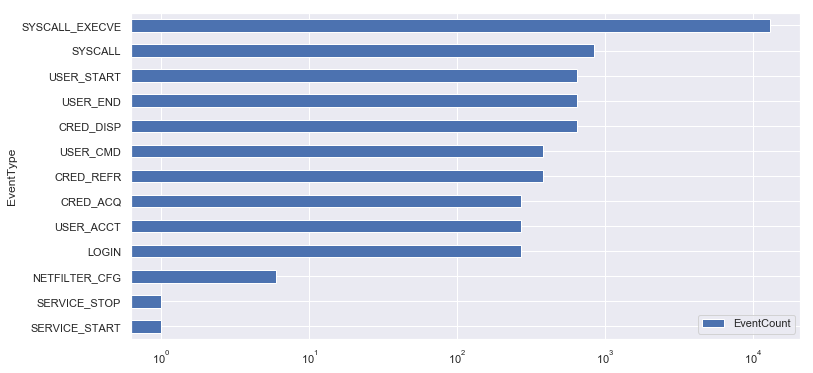

In [63]:
sns.set()
(linux_events_all[['EventType', 'TimeGenerated']]
     .groupby('EventType').count().rename(columns={'TimeGenerated': 'EventCount'})
     .sort_values('EventCount', ascending=True)
     .plot.barh(logx=True, figsize=(12,6)));

View events by Type - Process (SYSCALL) and Login events are covered in more detail below.
Use this to look at some of the rarer event types to see anything unusual.

In [64]:
# Lets look at the audit messages by type 
from ipywidgets import interactive

# We get the distinct list of event types
items = sorted(linux_events_all['EventType'].unique().tolist())

# this is a nice way of using a Select (list) widget to filter the display
# of the pandas dataframe. The interactive() call below tells the widget
# to call the view function each time an item is selected. The value of the
# item (EventType) is passed to the function and we use it to filter the DataFrame
# before displaying it.
def view(x=''):
    display(linux_events_all[linux_events_all['EventType']==x]
            .drop(['EventType', 'TenantId', 'Computer', 'mssg_id'], axis=1)
            .dropna(axis=1, how='all'))

w = widgets.Select(options=items, description='Select Event Type', **WIDGET_DEFAULTS)
interactive(view, x=w)

interactive(children=(Select(description='Select Event Type', layout=Layout(width='95%'), options=('CRED_ACQ',…

#### Extract Individual Event Types for logon and process events

In [65]:
from msticpy.sectools.auditdextract import extract_events_to_df, get_event_subset
lx_proc_create = get_event_subset(linux_events_all,'SYSCALL_EXECVE')
print(f'{len(lx_proc_create)} Process Create Events')

lx_login = (get_event_subset(linux_events_all, 'LOGIN')
        .merge(get_event_subset(linux_events_all, 'CRED_ACQ'), 
               how='inner',
               left_on=['old-ses', 'pid', 'uid'], 
               right_on=['ses', 'pid', 'uid'],
               suffixes=('', '_cred')).drop(['old-ses','TenantId_cred', 
                                             'Computer_cred'], axis=1)
        .dropna(axis=1, how='all'))
print(f'{len(lx_login)} Login Events')


13046 Process Create Events
269 Login Events


<a id='linux_failure_events'></a>[Contents](#toc)
### Failure Events
Can sometimes tell us about attempts to probe around the system that haven't quite worked.
Login failures will show up here as well.

In [66]:
lx_fail_events = (linux_events_all[linux_events_all['res'] == "failed'"]
                    .drop(['TenantId', 'mssg_id'], axis=1)
                    .dropna(axis=1, how='all'))
if len(lx_fail_events) > 0:
    display(lx_fail_events)
    add_observation(Observation(caption='Failure events on Linux host.',
                               description='One or more failure events detected on host.',
                               item=lx_fail_events,
                               link='linux_failure_events'))

<a id='linux_extract_ips'></a>[Contents](#toc)
### Extract IPs from all Events

In [67]:
# Search all events for addr field with an IPAddress (we're looking for any string with a '.'. 
# Drop duplicates and localhost and return list
events_with_ips = (linux_events_all[['EventType','addr']]
                   [linux_events_all['addr'].str.contains(r'\.', na=False)]
                   .drop_duplicates())

# Display any events found
display(events_with_ips)
# Get unique IPs and drop localhost
host_ext_ips = list(events_with_ips['addr'].drop_duplicates().to_dict().values())
if '127.0.0.1' in host_ext_ips:
    host_ext_ips.remove('127.0.0.1')
display(host_ext_ips)

,EventType,addr
5246,USER_ACCT,23.97.60.214
5247,CRED_ACQ,23.97.60.214
6112,USER_START,23.97.60.214
6301,USER_END,23.97.60.214
6302,CRED_DISP,23.97.60.214


['23.97.60.214']

<a id='linux_login_ips'></a>[Contents](#toc)
### Get Logins with IP Address Recorded

In [68]:
# From the logon events that we separated out a few cells back
# we can get the full event details of logons with external IPs                  

logins_with_ips = (lx_login[lx_login['addr'] != '?']
                   [['Computer', 'TimeGenerated','pid', 'ses', 
                     'acct', 'addr', 'exe', 'hostname', 'msg',
                     'res_cred', 'ses_cred', 'terminal']])
if len(logins_with_ips) > 0:
    display(logins_with_ips)
    add_observation(Observation(caption='Login events with source Ip addresses',
                                description=f'{len(logins_with_ips)} logins with external addresses',
                                item=logins_with_ips,
                                link='linux_login_ips'))


,Computer,TimeGenerated,pid,ses,acct,addr,exe,hostname,msg,res_cred,ses_cred,terminal
83,MSTICAlertsLxVM2,2019-02-18 15:29:20.115,24851,196045,dbadmin,23.97.60.214,/usr/sbin/sshd,23.97.60.214,'op=PAM:setcred,success',-1,ssh


<a id='linux_login_sessions'></a>[Contents](#toc)
### What's happening in these sessions?
If there are a lot of events here try the [Process Clustering](#linux_proc_cluster) section below.

In [69]:
# We can view the processes run by this logon by using the same DataFrame
# filtering trick.
# We don't have massive numbers of events but there is a lot of clutter and 
# it's not immediately obvious that anything bad is happening
items = sorted(lx_login[lx_login['addr'] != '?']['ses'].unique().tolist())

def view(x=''):
    procs = (lx_proc_create[lx_proc_create['ses']==x]
                [['TimeGenerated', 'exe','cmdline', 'pid','cwd']])
    display(Markdown(f'{len(procs)} process events'))
    display(procs)

w = widgets.Select(options=items, description='Select Session', **WIDGET_DEFAULTS)
interactive(view, x=w)


interactive(children=(Select(description='Select Session', layout=Layout(width='95%'), options=(196045,), styl…

<a id='linux_proc_cluster'></a>[Contents](#toc)
## Find Distinctive Process Patterns - Clustering
We can get rid of a lot of the clutter in the process data by clustering.
We'll look at this in more detail in the next part but it 
essentially collapses repetitive events into single items allowing
us to focus on distinctive events

In [70]:
# To use the clustering library we're going to cheat
# a little and make the Linux events look a bit more like
# Windows events. This isn't completely necessary but makes
# the code a bit simpler.

lx_to_proc_create = {'acct': 'SubjectUserName',
                     'uid': 'SubjectUserSid',
                     'user': 'SubjectUserName',
                     'ses': 'SubjectLogonId',
                     'pid': 'NewProcessId',
                     'exe': 'NewProcessName',
                     'ppid': 'ProcessId',
                     'cmdline': 'CommandLine',}

proc_create_to_lx = {'SubjectUserName': 'acct',
                     'SubjectUserSid': 'uid',
                     'SubjectUserName': 'user',
                     'SubjectLogonId': 'ses',
                     'NewProcessId': 'pid',
                     'NewProcessName': 'exe',
                     'ProcessId': 'ppid',
                     'CommandLine': 'cmdline',}

lx_to_logon = {'acct': 'SubjectUserName',
               'auid': 'SubjectUserSid',
               'user': 'TargetUserName',
               'uid': 'TargetUserSid',
               'ses': 'TargetLogonId',
               'exe': 'LogonProcessName',
               'terminal': 'LogonType',
               'msg': 'AuthenticationPackageName',
               'res': 'Status',
               'addr': 'IpAddress',
               'hostname': 'WorkstationName',}

logon_to_lx = {'SubjectUserName': 'acct',
               'SubjectUserSid': 'auid',
               'TargetUserName': 'user',
               'TargetUserSid': 'uid',
               'TargetLogonId': 'ses',
               'LogonProcessName': 'exe',
               'LogonType': 'terminal',
               'AuthenticationPackageName': 'msg',
               'Status': 'res',
               'IpAddress': 'addr',
               'WorkstationName': 'hostname',}

lx_proc_create_trans = lx_proc_create.rename(columns=lx_to_proc_create)
lx_login_trans = lx_login.rename(columns=lx_to_logon)

In [71]:
# For demo purposes we're actually running the clustering 
# algorithm against all 13k or so process exec events
# and we can see that it's reduced the unique items to 1%
# of the original volume
print('analyzing data...')
from msticpy.sectools.eventcluster import dbcluster_events, add_process_features

feature_procs_h1 = add_process_features(input_frame=lx_proc_create_trans,
                                        path_separator=security_alert.path_separator)


# you might need to play around with the max_cluster_distance parameter.
# decreasing this gives more clusters.
(clus_events, dbcluster, x_data) = dbcluster_events(data=feature_procs_h1,
                                                    cluster_columns=['commandlineTokensFull', 
                                                                     'pathScore',
                                                                    'SubjectUserSid'],
                                                    time_column='TimeGenerated',
                                                    max_cluster_distance=0.0001)
print('Number of input events:', len(feature_procs_h1))
print('Number of clustered events:', len(clus_events))
(clus_events.sort_values('TimeGenerated')[['TimeGenerated', 'LastEventTime',
                                           'NewProcessName', 'CommandLine', 
                                           'ClusterSize', 'commandlineTokensFull',
                                           'SubjectLogonId', 'SubjectUserSid',
                                           'pathScore', 'isSystemSession']]
    .sort_values('ClusterSize', ascending=True));

analyzing data...
Number of input events: 13046
Number of clustered events: 138


In [72]:
# Lets try viewing our session again
# For interactive sessions the compression won't be as good
# but we've reduced it to about 20% of the original

def view(x=''):
    procs = (clus_events[clus_events['SubjectLogonId']==x]
            [['TimeGenerated', 'NewProcessName','CommandLine', 
              'NewProcessId', 'SubjectUserSid', 'cwd', 'ClusterSize', 'SubjectLogonId']])
    display(Markdown(f'{len(procs)} process events'))
    display(procs)

w = widgets.Select(options=items, description='Select Session to view', **WIDGET_DEFAULTS)
interactive(view, x=w)

interactive(children=(Select(description='Select Session to view', layout=Layout(width='95%'), options=(196045…

### Badness Uncovered!
On a single screen we can now scan down the whole session and see
pretty quickly some very suspicious activity:

- Reconnaisance - getting machine info, contents of /etc/passwd and mail
- Downloading a script and making it executable
- The crontab command is not entirely clear (likely the start of a pipeline) but it
  seems a good bet that the script is being installed as a cron job

In [73]:
# Let's save our first piece of real evidence in our summary collection
selected_session = w.value
add_observation(Observation(caption='Suspicious Process Session on Linux Host.',
                            description='Attempt to download and run script + recon cmds.',
                            item = clus_events.query('SubjectLogonId == @selected_session & ClusterSize < 3'),
                            link='linux_proc_cluster'))

<a id='alert_host_net'></a>[Contents](#toc)
# Part 2b - Host Network Data

## Get the IP Address of the Source Host

In [74]:
                   

host_entities = [e for e in security_alert.entities if isinstance(e, nbtools.Host)]
if len(host_entities) == 1:
    alert_host_entity = host_entities[0]
    host_name = alert_host_entity.HostName
    resource = alert_host_entity.AzureID
else:
    host_name = None
    alert_host_entity = None
    print('Error: Could not determine host entity from alert. Please type the hostname below')
txt_wgt = widgets.Text(value=host_name, description='Confirm Source Host name:', **WIDGET_DEFAULTS)
display(txt_wgt)

Text(value='MSTICALERTSLXVM2', description='Confirm Source Host name:', layout=Layout(width='95%'), style=Desc…

In [75]:
             

print('Looking for IP addresses of ', txt_wgt.value)
aznet_query = '''
AzureNetworkAnalytics_CL 
| where VirtualMachine_s has \'{host}\'
| where ResourceType == 'NetworkInterface'
| top 1 by TimeGenerated desc
| project PrivateIPAddresses = PrivateIPAddresses_s, 
    PublicIPAddresses = PublicIPAddresses_s
'''.format(host=txt_wgt.value)
%kql -query aznet_query
az_net_df = _kql_raw_result_.to_dataframe()


oms_heartbeat_query = '''
Heartbeat
| where Computer has \'{host}\'
| top 1 by TimeGenerated desc nulls last
| project ComputerIP, OSType, OSMajorVersion, OSMinorVersion, ResourceId, RemoteIPCountry, 
RemoteIPLatitude, RemoteIPLongitude, SourceComputerId
'''.format(host=txt_wgt.value)
%kql -query oms_heartbeat_query
oms_heartbeat_df = _kql_raw_result_.to_dataframe()
display(oms_heartbeat_df[['ComputerIP']])
display(az_net_df)

print('getting data...')
# Get the host entity and add this IP and system info to the 
try:
    if not inv_host_entity:
        inv_host_entity = entity.Host()
        inv_host_entity.HostName = host_name
except NameError:
    inv_host_entity = entity.Host()
    inv_host_entity.HostName = host_name

def convert_to_ip_entities(ip_str):
    ip_entities = []
    if ip_str:
        if ',' in ip_str:
            addrs = ip_str.split(',')
        elif ' ' in ip_str:
            addrs = ip_str.split(' ')
        else:
            addrs = [ip_str]
        for addr in addrs:
            ip_entity = entity.IpAddress()
            ip_entity.Address = addr.strip()
            iplocation.lookup_ip(ip_entity=ip_entity)
            ip_entities.append(ip_entity)
    return ip_entities

# Add this information to our inv_host_entity
retrieved_address=[]
if len(az_net_df) == 1:
    priv_addr_str = az_net_df['PrivateIPAddresses'].loc[0]
    inv_host_entity.properties['private_ips'] = convert_to_ip_entities(priv_addr_str)

    pub_addr_str = az_net_df['PublicIPAddresses'].loc[0]
    inv_host_entity.properties['public_ips'] = convert_to_ip_entities(pub_addr_str)
    retrieved_address = [ip.Address for ip in inv_host_entity.properties['public_ips']]
else:
    if 'private_ips' not in inv_host_entity.properties:
        inv_host_entity.properties['private_ips'] = []
    if 'public_ips' not in inv_host_entity.properties:
        inv_host_entity.properties['public_ips'] = []
        
if len(oms_heartbeat_df) == 1:
    if oms_heartbeat_df['ComputerIP'].loc[0]:
        oms_address = oms_heartbeat_df['ComputerIP'].loc[0]
        if oms_address not in retrieved_address:
            ip_entity = entity.IpAddress()
            ip_entity.Address = oms_address
            iplocation.lookup_ip(ip_entity=ip_entity)
            inv_host_entity.properties['public_ips'].append(ip_entity)
        
    inv_host_entity.OSFamily = oms_heartbeat_df['OSType'].loc[0]
    inv_host_entity.AdditionalData['OSMajorVersion'] = oms_heartbeat_df['OSMajorVersion'].loc[0]
    inv_host_entity.AdditionalData['OSMinorVersion'] = oms_heartbeat_df['OSMinorVersion'].loc[0]
    inv_host_entity.AdditionalData['SourceComputerId'] = oms_heartbeat_df['SourceComputerId'].loc[0]

print('Updated Host Entity\n')
print(inv_host_entity)

Looking for IP addresses of  MSTICALERTSLXVM2


,ComputerIP
0,104.211.30.1


,PrivateIPAddresses,PublicIPAddresses
0,10.0.3.4,104.211.30.1


getting data...
Updated Host Entity

{ 'AdditionalData': { 'OSMajorVersion': '18',
                      'OSMinorVersion': '04',
                      'SourceComputerId': '44623fb0-bd5f-49ea-84d1-56aa11ab8a25'},
  'HostName': 'MSTICALERTSLXVM2',
  'OSFamily': 'Linux',
  'Type': 'host',
  'private_ips': [{"Address": "10.0.3.4", "Type": "ipaddress"}],
  'public_ips': [ {"Address": "104.211.30.1", "Location": {"CountryCode": "US", "CountryName": "United States", "State": "Virginia", "City": "Washington", "Longitude": -78.1704, "Latitude": 38.7163, "Type": "geolocation"}, "Type": "ipaddress"}]}


<a id='comms_to_other_hosts'></a>[Contents](#toc)
## Check Communications with Other Hosts

In [76]:
                   

# Azure Network Analytics Base Query
az_net_analytics_query =r'''
AzureNetworkAnalytics_CL 
| where SubType_s == 'FlowLog'
| where FlowStartTime_t >= datetime({start})
| where FlowEndTime_t <= datetime({end})
| project TenantId, TimeGenerated, 
    FlowStartTime = FlowStartTime_t, 
    FlowEndTime = FlowEndTime_t, 
    FlowIntervalEndTime = FlowIntervalEndTime_t, 
    FlowType = FlowType_s,
    ResourceGroup = split(VM_s, '/')[0],
    VMName = split(VM_s, '/')[1],
    VMIPAddress = VMIP_s, 
    PublicIPs = extractall(@"([\d\.]+)[|\d]+", dynamic([1]), PublicIPs_s),
    SrcIP = SrcIP_s,
    DestIP = DestIP_s,
    ExtIP = iif(FlowDirection_s == 'I', SrcIP_s, DestIP_s),
    L4Protocol = L4Protocol_s, 
    L7Protocol = L7Protocol_s, 
    DestPort = DestPort_d, 
    FlowDirection = FlowDirection_s,
    AllowedOutFlows = AllowedOutFlows_d, 
    AllowedInFlows = AllowedInFlows_d,
    DeniedInFlows = DeniedInFlows_d, 
    DeniedOutFlows = DeniedOutFlows_d,
    RemoteRegion = AzureRegion_s,
    VMRegion = Region_s
| extend AllExtIPs = iif(isempty(PublicIPs), pack_array(ExtIP), 
                         iif(isempty(ExtIP), PublicIPs, array_concat(PublicIPs, pack_array(ExtIP)))
                         )
| project-away ExtIP
| mvexpand AllExtIPs
{where_clause}
'''

ip_q_times = nbtools.QueryTime(label='Set time bounds for network queries',
                           units='hour', max_before=48, before=10, after=5, 
                           max_after=24, origin_time=security_alert.StartTimeUtc)
ip_q_times.display()

HTML(value='<h4>Set time bounds for network queries</h4>')

### Query Flows by Host IP Addresses

In [77]:
                   

all_alert_host_ips = inv_host_entity.private_ips + inv_host_entity.public_ips
host_ips = {'\'{}\''.format(i.Address) for i in all_alert_host_ips}
alert_host_ip_list = ','.join(host_ips)

az_ip_where = f'''
| where (VMIPAddress in ({alert_host_ip_list}) 
        or SrcIP in ({alert_host_ip_list}) 
        or DestIP in ({alert_host_ip_list}) 
        ) and 
    (AllowedOutFlows > 0 or AllowedInFlows > 0)'''
print('getting data...')
az_net_query_byip = az_net_analytics_query.format(where_clause=az_ip_where,
                                                  start = ip_q_times.start,
                                                  end = ip_q_times.end)

net_default_cols = ['FlowStartTime', 'FlowEndTime', 'VMName', 'VMIPAddress', 
                'PublicIPs', 'SrcIP', 'DestIP', 'L4Protocol', 'L7Protocol',
                'DestPort', 'FlowDirection', 'AllowedOutFlows', 
                'AllowedInFlows']

%kql -query az_net_query_byip
az_net_comms_df = _kql_raw_result_.to_dataframe()
az_net_comms_df[net_default_cols]

getting data...


,FlowStartTime,FlowEndTime,VMName,VMIPAddress,PublicIPs,SrcIP,DestIP,L4Protocol,L7Protocol,DestPort,FlowDirection,AllowedOutFlows,AllowedInFlows
0,2019-02-18 06:59:14,2019-02-18 07:58:56,msticalertslxvm2,10.0.3.4,"[13.71.172.130, 13.88.255.115, 40.85.232.64, 13.71.172.128]",,,T,https,443.0,O,628.0,0.0
1,2019-02-18 06:59:14,2019-02-18 07:58:56,msticalertslxvm2,10.0.3.4,"[13.71.172.130, 13.88.255.115, 40.85.232.64, 13.71.172.128]",,,T,https,443.0,O,628.0,0.0
2,2019-02-18 06:59:14,2019-02-18 07:58:56,msticalertslxvm2,10.0.3.4,"[13.71.172.130, 13.88.255.115, 40.85.232.64, 13.71.172.128]",,,T,https,443.0,O,628.0,0.0
3,2019-02-18 06:59:14,2019-02-18 07:58:56,msticalertslxvm2,10.0.3.4,"[13.71.172.130, 13.88.255.115, 40.85.232.64, 13.71.172.128]",,,T,https,443.0,O,628.0,0.0
4,2019-02-18 07:33:36,2019-02-18 07:33:36,msticalertslxvm2,10.0.3.4,[52.168.50.79],,,T,http,80.0,O,1.0,0.0
5,2019-02-18 07:24:15,2019-02-18 07:58:23,msticalertslxvm2,10.0.3.4,[91.189.94.4],,,U,ntp,123.0,O,2.0,0.0
6,2019-02-18 06:59:02,2019-02-18 07:58:59,msticalertslxvm2,10.0.3.4,"[52.239.220.32, 168.62.32.212, 52.239.220.64, 20.38.98.164]",,,T,https,443.0,O,2348.0,0.0
7,2019-02-18 06:59:02,2019-02-18 07:58:59,msticalertslxvm2,10.0.3.4,"[52.239.220.32, 168.62.32.212, 52.239.220.64, 20.38.98.164]",,,T,https,443.0,O,2348.0,0.0
8,2019-02-18 06:59:02,2019-02-18 07:58:59,msticalertslxvm2,10.0.3.4,"[52.239.220.32, 168.62.32.212, 52.239.220.64, 20.38.98.164]",,,T,https,443.0,O,2348.0,0.0
9,2019-02-18 06:59:02,2019-02-18 07:58:59,msticalertslxvm2,10.0.3.4,"[52.239.220.32, 168.62.32.212, 52.239.220.64, 20.38.98.164]",,,T,https,443.0,O,2348.0,0.0


<a id="net_flow_graphs"></a>
### Flow Time and Protocol Distribution

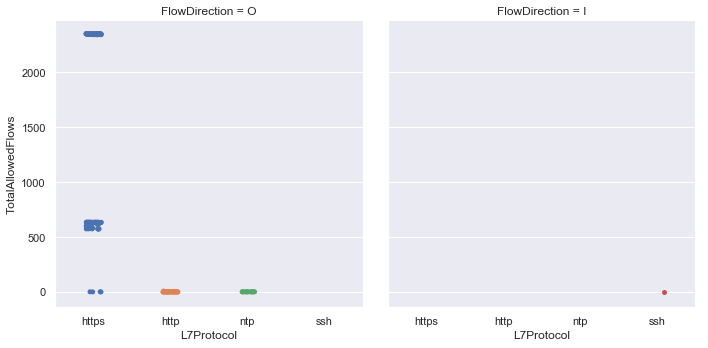

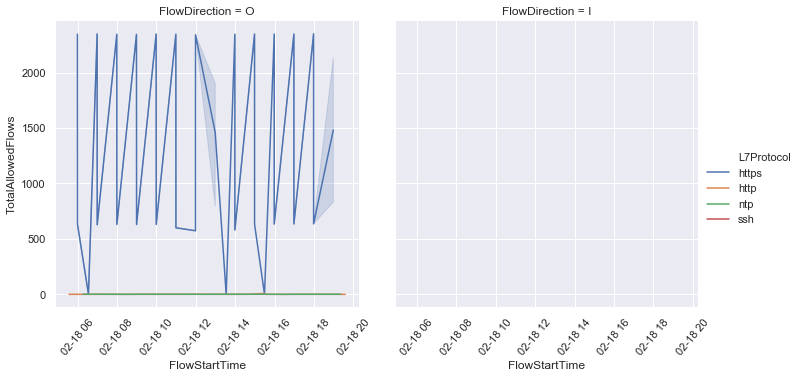

In [78]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    az_net_comms_df['TotalAllowedFlows'] = az_net_comms_df['AllowedOutFlows'] + az_net_comms_df['AllowedInFlows']
    sns.catplot(x="L7Protocol", y="TotalAllowedFlows", col="FlowDirection", data=az_net_comms_df)
    sns.relplot(x="FlowStartTime", y="TotalAllowedFlows", 
                col="FlowDirection", kind="line", 
                hue="L7Protocol", data=az_net_comms_df).set_xticklabels(rotation=50)

#### Isolated SSH traffic

In [79]:
az_net_comms_df.query('FlowDirection == \'I\' & L7Protocol == \'ssh\'')[net_default_cols]

,FlowStartTime,FlowEndTime,VMName,VMIPAddress,PublicIPs,SrcIP,DestIP,L4Protocol,L7Protocol,DestPort,FlowDirection,AllowedOutFlows,AllowedInFlows
93,2019-02-18 15:29:18,2019-02-18 15:29:18,None,,None,23.97.60.214,10.0.3.4,T,ssh,22.0,I,0.0,1.0


#### Seems suspicious, so Record findings

In [80]:


ext_ip_list = az_net_comms_df.query('FlowDirection == \'I\' & L7Protocol == \'ssh\'')['AllExtIPs'].tolist()

for ip in ext_ip_list:
    if not ip:
        continue
    # Check IP is not already in our list of entities
    if ip in [curr_ip.Address for curr_ip in alert_ip_entities]:
        continue
    ip_entity = entity.IpAddress(Address=ip)
    iplocation.lookup_ip(ip_entity=ip_entity)
    
    alert_ip_entities.append(ip_entity)
    
add_observation(Observation(caption='Outlier SSH session on Linux Host.',
                            description='''Plot of in/out flows shows unexpected ssh inbound. 
Ip Address confirmed as logon source for SSH.''',
                            item = az_net_comms_df.query('FlowDirection == \'I\' & L7Protocol == \'ssh\''),
                            link='net_flow_graphs'))


### Interactive Flow Timeline

In [81]:

nbdisp.display_timeline(data=az_net_comms_df.query('AllowedOutFlows > 0'),
                         overlay_data=az_net_comms_df.query('AllowedInFlows > 0'),
                         alert=security_alert, title='Network Flows (out=blue, in=green)',
                         time_column='FlowStartTime',
                         source_columns=['FlowType', 'AllExtIPs', 'L7Protocol', 'FlowDirection'],
                         height=300)

Loading BokehJS ...

Alert start time =  2019-02-18 15:29:22


C:\Users\ianhelle\AppData\Local\Continuum\anaconda3\envs\condadev\lib\site-packages\bokeh\core\property\container.py:102: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working



<a id='geomap_lx_ips'></a>[Contents](#toc)
## GeoLocation Mapping

In [86]:


ip_locs_in = set()
ip_locs_out = set()
for _, row in az_net_comms_df.iterrows():
    ip = row.AllExtIPs

    if ip in ip_locs_in or ip in ip_locs_out or not ip:
        continue
    ip_entity = entity.IpAddress(Address=ip)
    iplocation.lookup_ip(ip_entity=ip_entity)
    if not ip_entity.Location:
        continue
    ip_entity.AdditionalData['protocol'] = row.L7Protocol
    if row.FlowDirection == 'I':
        ip_locs_in.add(ip_entity)
    else:
        ip_locs_out.add(ip_entity)

flow_map = FoliumMap()
display(HTML('<h3>External IP Addresses communicating with host</h3>'))
display(HTML('Numbered circles indicate multiple items - click to expand'))
display(HTML('Location markers: Blue = outbound, Purple = inbound, Green = Host'))

flow_map.add_ip_cluster(ip_entities=inv_host_entity.public_ips,
                        color='green')
flow_map.add_ip_cluster(ip_entities=ip_locs_out,
                        color='blue')
flow_map.add_ip_cluster(ip_entities=ip_locs_in,
                        color='red')

display(flow_map.folium_map)
display(Markdown('<p style="color:red">Warning: the folium mapping library '
                 'does not display correctly in some browsers.</p><br>'
                 'If you see a blank image please retry with a different browser.'))

<p style="color:red">Warning: the folium mapping library does not display correctly in some browsers.</p><br>If you see a blank image please retry with a different browser.

### Look at 'Denied' Flows - who's trying to get in from where?
#### Optional and can take a long time

In [89]:
# Comment this out to run automatically
if True:
    az_ip_where = f'''
    | where (VMIPAddress in ({alert_host_ip_list}) 
            or SrcIP in ({alert_host_ip_list}) 
            or DestIP in ({alert_host_ip_list}) 
            )'''

    az_net_query_byip = az_net_analytics_query.format(where_clause=az_ip_where,
                                                      start = ip_q_times.start,
                                                      end = ip_q_times.end)
    %kql -query az_net_query_byip
    az_net_comms_all_df = _kql_raw_result_.to_dataframe()

    ip_all = set()
    ip_locs_in_allow = set()
    ip_locs_out_allow = set()
    ip_locs_in_deny = set()
    ip_locs_out_deny = set()
    for _, row in az_net_comms_all_df.iterrows():
        if not row.PublicIPs:
            continue
        for ip in row.PublicIPs:
            if ip in ip_all:
                continue
            ip_all.add(ip)
            ip_entity = entity.IpAddress(Address=ip)
            iplocation.lookup_ip(ip_entity=ip_entity)
            if not ip_entity.Location:
                print("No location information for IP: ", ip)
                continue
            ip_entity.AdditionalData['protocol'] = row.L7Protocol
            if row.FlowDirection == 'I':
                if row.AllowedInFlows > 0:
                    ip_locs_in_allow.add(ip_entity)
                elif row.DeniedInFlows > 0:
                    ip_locs_in_deny.add(ip_entity)
            else:
                if row.AllowedOutFlows > 0:
                    ip_locs_out_allow.add(ip_entity)
                elif row.DeniedOutFlows > 0:
                    ip_locs_out_deny.add(ip_entity)

    flow_map = FoliumMap()
    display(HTML('<h3>External IP Addresses Blocked and Allowed communicating with host</h3>'))
    display(HTML('Numbered circles indicate multiple items - click to expand.'))
    display(HTML('Location markers: Blue = outbound, Purple = inbound, Red = in denied, Cyan = out denied.'))

    flow_map.add_ip_cluster(ip_entities=ip_locs_in_allow,
                            color='purple')
    flow_map.add_ip_cluster(ip_entities=ip_locs_out_allow,
                            color='blue')
    flow_map.add_ip_cluster(ip_entities=ip_locs_in_deny,
                            color='red')
    flow_map.add_ip_cluster(ip_entities=ip_locs_out_deny,
                            color='cyan')
    display(flow_map.folium_map)
    
    display(Markdown('<p style="color:red">Warning: the folium mapping library '
                     'does not display correctly in some browsers.</p><br>'
                     'If you see a blank image please retry with a different browser.'))

No location information for IP:  193.32.161.50
No location information for IP:  88.214.26.103
No location information for IP:  81.22.45.116
No location information for IP:  88.214.26.77
No location information for IP:  81.22.45.102
No location information for IP:  88.214.26.38
No location information for IP:  141.98.80.150
No location information for IP:  193.32.160.69
No location information for IP:  194.61.24.198
No location information for IP:  81.22.45.81
No location information for IP:  81.22.45.106


e:\src\microsoft\msticpy\msticpy\msticpy\nbtools\foliummap.py:73: RuntimeWarning:

Invalid location information for IP: 194.113.106.162

e:\src\microsoft\msticpy\msticpy\msticpy\nbtools\foliummap.py:73: RuntimeWarning:

Invalid location information for IP: 194.147.32.125



<p style="color:red">Warning: the folium mapping library does not display correctly in some browsers.</p><br>If you see a blank image please retry with a different browser.

### DNS Activity Includes any of these IPs?

In [90]:

dns_query =r'''
DnsEvents
| where ClientIP in ({ip_list})
'''.format(ip_list=', '.join([f'\'{ip.Address}\'' for ip in alert_ip_entities]))

%kql -query dns_query
dns_df = _kql_raw_result_.to_dataframe()
dns_df

,TenantId,Computer,SourceSystem,TimeGenerated,EventId,SubType,ClientIP,Name,Result,IPAddresses,Message,TaskCategory,QueryType,ResultCode,MaliciousIP,IndicatorThreatType,Description,Confidence,Severity,ReportReferenceLink,RemoteIPLongitude,RemoteIPLatitude,RemoteIPCountry,Type,_ResourceId


<a id='other_hosts_to_ips'></a>[Contents](#toc)
## Have any other hosts been communicating with this address(es)?

In [91]:
ip_q_times = nbtools.QueryTime(units='day', max_before=10, before=3, after=1, max_after=10, origin_time=security_alert.StartTimeUtc)
ip_q_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [92]:

alert_ips = {'\'{}\''.format(i.Address) for i in alert_ip_entities}
alert_host_ip_list = ','.join(alert_ips)

az_ip_where = f'| where AllExtIPs in ({alert_host_ip_list})'

az_net_query_by_pub_ip = az_net_analytics_query.format(where_clause=az_ip_where,
                                                       start = ip_q_times.start,
                                                       end = ip_q_times.end)
print('getting data...')
%kql -query az_net_query_by_pub_ip
az_net_ext_comms_df = _kql_raw_result_.to_dataframe()
az_net_ext_comms_df[net_default_cols]

# az_net_ext_comms_df.groupby(['VMName', 'L7Protocol'])['AllowedOutFlows','AllowedInFlows','DeniedInFlows','DeniedOutFlows'].sum()

getting data...


,FlowStartTime,FlowEndTime,VMName,VMIPAddress,PublicIPs,SrcIP,DestIP,L4Protocol,L7Protocol,DestPort,FlowDirection,AllowedOutFlows,AllowedInFlows
0,2019-02-18 15:29:22,2019-02-18 15:29:38,None,,None,10.0.3.4,23.97.60.214,T,http,80.0,O,9.0,0.0
1,2019-02-18 15:29:18,2019-02-18 15:29:18,None,,None,23.97.60.214,10.0.3.4,T,ssh,22.0,I,0.0,1.0
2,2019-02-16 19:35:07,2019-02-16 19:35:07,None,,None,23.97.60.214,10.0.3.4,T,ssh,22.0,I,0.0,1.0
3,2019-02-16 13:35:07,2019-02-16 13:35:07,None,,None,23.97.60.214,10.0.3.4,T,ssh,22.0,I,0.0,1.0
4,2019-02-16 16:35:07,2019-02-16 16:35:07,None,,None,23.97.60.214,10.0.3.4,T,ssh,22.0,I,0.0,1.0
5,2019-02-16 10:35:07,2019-02-16 10:35:07,None,,None,23.97.60.214,10.0.3.4,T,ssh,22.0,I,0.0,1.0
6,2019-02-16 07:35:07,2019-02-16 07:35:07,None,,None,23.97.60.214,10.0.3.4,T,ssh,22.0,I,0.0,1.0
7,2019-02-16 04:35:07,2019-02-16 04:35:07,None,,None,23.97.60.214,10.0.3.4,T,ssh,22.0,I,0.0,1.0
8,2019-02-16 03:51:57,2019-02-16 03:52:13,None,,None,10.0.3.4,23.97.60.214,T,http,80.0,O,9.0,0.0
9,2019-02-16 03:10:55,2019-02-16 03:24:44,None,,None,23.97.60.214,10.0.3.5,T,ms-wbt-server,3389.0,I,0.0,6.0


In [93]:


inv_host_ips = [ent.Address for ent in inv_host_entity.private_ips]
inv_host_ips += [ent.Address for ent in inv_host_entity.public_ips]

alert_ips = [ip.Address for ip in alert_ip_entities]

known_ips = inv_host_ips + alert_ips

# Ips can be in one of 4 columns!
def find_new_ips(known_ips, row):
    new_ips = set()
    if row.VMIPAddress and row.VMIPAddress not in known_ips:
        new_ips.add(row.VMIPAddress)
    if row.SrcIP and row.SrcIP not in known_ips:
        new_ips.add(row.SrcIP)
    if row.DestIP and row.DestIP not in known_ips:
        new_ips.add(row.DestIP)
    if row.PublicIPs:
        for pub_ip in row.PublicIPs:
            if pub_ip not in known_ips:
                new_ips.add(pub_ip)
    if new_ips:            
        return list(new_ips)

new_ips_all = az_net_ext_comms_df.apply(lambda x: find_new_ips(known_ips, x), axis=1).dropna()
new_ips = set()
for ip in [ip for item in new_ips_all for ip in item]:
    new_ips.add(ip)
display(Markdown(f'#### {len(new_ips)} unseen IP Address found in this data: {list(new_ips)}'))

#### 1 unseen IP Address found in this data: ['10.0.3.5']

### Note you should re-run this section for each new IP Address found to determine who it belongs to

In [94]:
items = list(new_ips)
ip_w = widgets.Select(options=items, 
                   description='Select ip address to search for',
                   value=items[0] if items else None,
                   **WIDGET_DEFAULTS)
display(ip_w)

Select(description='Select ip address to search for', layout=Layout(width='95%'), options=('10.0.3.5',), style…

In [95]:


vm_ip = ip_w.value
aznet_query = '''
AzureNetworkAnalytics_CL 
| where PrivateIPAddresses_s has \'{vm_ip}\'
| where ResourceType == 'NetworkInterface'
| top 1 by TimeGenerated desc
| project PrivateIPAddresses = PrivateIPAddresses_s, 
    PublicIPAddresses = PublicIPAddresses_s,
    VirtualMachine = VirtualMachine_s
| extend Host = split(VirtualMachine, '/')[-1]
'''.format(vm_ip=vm_ip)
%kql -query aznet_query
az_net_df = _kql_raw_result_.to_dataframe()
if len(az_net_df) > 0:
    host_name = az_net_df['Host'].at[0]

oms_heartbeat_query = '''
Heartbeat
| where ComputerIP == \'{vm_ip}\'
| top 1 by TimeGenerated desc nulls last
| project Computer, ComputerIP, OSType, OSMajorVersion, OSMinorVersion, ResourceId, RemoteIPCountry, 
RemoteIPLatitude, RemoteIPLongitude, SourceComputerId
'''.format(vm_ip=vm_ip)
%kql -query oms_heartbeat_query
oms_heartbeat_df = _kql_raw_result_.to_dataframe()
if len(oms_heartbeat_df) > 0:
    host_name = oms_heartbeat_df['Computer'].at[0]
    

# Get the host entity and add this IP and system info to the 
try:
    if not victim_host_entity:
        victim_host_entity = entity.Host()
        victim_host_entity.HostName = host_name
except NameError:
    victim_host_entity = entity.Host()
    victim_host_entity.HostName = host_name

def convert_to_ip_entities(ip_str):
    ip_entities = []
    if ip_str:
        if ',' in ip_str:
            addrs = ip_str.split(',')
        elif ' ' in ip_str:
            addrs = ip_str.split(' ')
        else:
            addrs = [ip_str]
        for addr in addrs:
            ip_entity = entity.IpAddress()
            ip_entity.Address = addr.strip()
            iplocation.lookup_ip(ip_entity=ip_entity)
            ip_entities.append(ip_entity)
    return ip_entities

# Add this information to our inv_host_entity
retrieved_pub_addresses = []
if len(az_net_df) == 1:
    priv_addr_str = az_net_df['PrivateIPAddresses'].loc[0]
    victim_host_entity.properties['private_ips'] = convert_to_ip_entities(priv_addr_str)

    pub_addr_str = az_net_df['PublicIPAddresses'].loc[0]
    victim_host_entity.properties['public_ips'] = convert_to_ip_entities(pub_addr_str)
    retrieved_pub_addresses = [ip.Address for ip in victim_host_entity.properties['public_ips']]
    
if len(oms_heartbeat_df) == 1:
    if oms_heartbeat_df['ComputerIP'].loc[0]:
        oms_address = oms_heartbeat_df['ComputerIP'].loc[0]
        if oms_address not in retrieved_address:
            ip_entity = entity.IpAddress()
            ip_entity.Address = oms_address
            iplocation.lookup_ip(ip_entity=ip_entity)
            inv_host_entity.properties['public_ips'].append(ip_entity)
        
    victim_host_entity.OSFamily = oms_heartbeat_df['OSType'].loc[0]
    victim_host_entity.AdditionalData['OSMajorVersion'] = oms_heartbeat_df['OSMajorVersion'].loc[0]
    victim_host_entity.AdditionalData['OSMinorVersion'] = oms_heartbeat_df['OSMinorVersion'].loc[0]
    victim_host_entity.AdditionalData['SourceComputerId'] = oms_heartbeat_df['SourceComputerId'].loc[0]

print(f'Found New Host Entity {victim_host_entity.HostName}\n')
print(victim_host_entity)

add_observation(Observation(caption=f'Second victim host identified {victim_host_entity.HostName}',
                            description='Description of host entity shown in attachment.',
                            item=victim_host_entity,
                            link='other_hosts_to_ips'))

Found New Host Entity msticalertswin1

{ 'HostName': 'msticalertswin1',
  'Type': 'host',
  'private_ips': [{"Address": "10.0.3.5", "Type": "ipaddress"}],
  'public_ips': [ {"Address": "40.76.43.124", "Location": {"CountryCode": "US", "CountryName": "United States", "State": "Virginia", "City": "Washington", "Longitude": -78.1704, "Latitude": 38.7163, "Type": "geolocation"}, "Type": "ipaddress"}]}


In [97]:
alert_ip_entities

[{"Address": "23.97.60.214", "Type": "ipaddress"}]

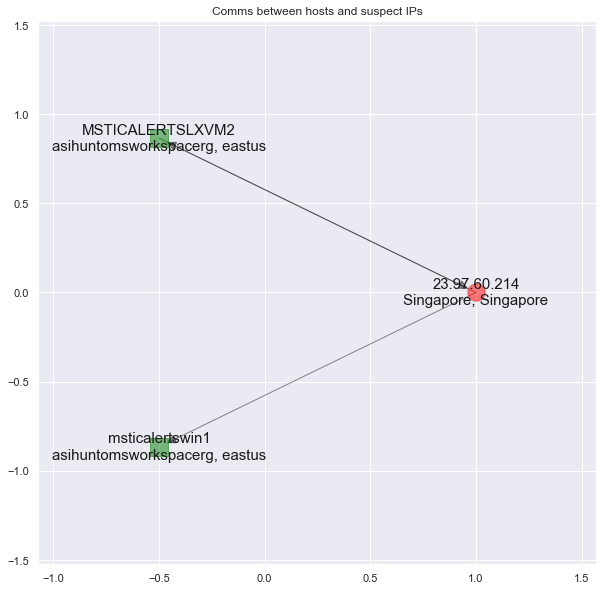

In [98]:


sns.set()
from matplotlib import MatplotlibDeprecationWarning
warnings.simplefilter("ignore", category=MatplotlibDeprecationWarning)

ip_graph = nx.DiGraph(id='IPGraph')

def add_vm_node(graph, host_entity):
    vm_name = host_entity.HostName
    vm_ip = host_entity.private_ips[0].Address
    vm_desc = f'{host_entity.HostName}\n{row.ResourceGroup}, {row.VMRegion}'
    ip_graph.add_node(vm_ip, name=vm_name, description=vm_desc,
                      node_type='host')

for ip_entity in alert_ip_entities:
    if 'Location' not in ip_entity:
        iplocation.lookup_ip(ip_entity=ip_entity)
    if 'Location' in ip_entity:
        ip_desc = f'{ip_entity.Address}\n{ip_entity.Location.City}, {ip_entity.Location.CountryName}'
    else:
        ip_desc = 'unknown location'
    ip_graph.add_node(ip_entity.Address, name=ip_entity.Address, description=ip_desc, node_type='ip')

add_vm_node(ip_graph, inv_host_entity)
add_vm_node(ip_graph, victim_host_entity)


def add_edges(graph, row): 
    dest_ip = row.DestIP if row.DestIP else row.VMIPAddress
    if row.SrcIP:
        src_ip = row.SrcIP
        ip_graph.add_edge(src_ip, dest_ip)
    else:
        for ip in row.PublicIPs:
            src_ip = ip
            ip_graph.add_edge(src_ip, dest_ip)

    
# Add edges from network data
az_net_ext_comms_df.apply(lambda x: add_edges(ip_graph, x),axis=1)

src_node = [n for (n, node_type) in
            nx.get_node_attributes(ip_graph, 'node_type').items()
            if node_type == 'ip']
vm_nodes = [n for (n, node_type) in
            nx.get_node_attributes(ip_graph, 'node_type').items()
            if node_type == 'host']

# now draw them in subsets  using the `nodelist` arg
plt.rcParams['figure.figsize'] = (10, 10)
plt.margins(x=0.3, y=0.3)
plt.title('Comms between hosts and suspect IPs')
pos = nx.circular_layout(ip_graph)
nx.draw_networkx_nodes(ip_graph, pos, nodelist=src_node,
                       node_color='red', alpha=0.5, node_shape='o')
nx.draw_networkx_nodes(ip_graph, pos, nodelist=vm_nodes,
                       node_color='green', alpha=0.5, node_shape='s',
                       s=400)
nlabels = nx.get_node_attributes(ip_graph, 'description')
nx.relabel_nodes(ip_graph, nlabels)
nx.draw_networkx_labels(ip_graph, pos, nlabels, font_size=15)
nx.draw_networkx_edges(ip_graph, pos, alpha=0.5, arrows=True, arrowsize=20);


<a id='other_host_investigate'></a>[Contents](#toc)
# Part 3 - Windows Host and Office 365

___

# Other Hosts Communicating with IP

<a id='host_logons'></a>[Contents](#toc)
## Check Host Logons

In [99]:


from msticpy.nbtools.query_defns import DataFamily, DataEnvironment
params_dict = {}
params_dict.update(security_alert.query_params)
params_dict['host_filter_eq'] = f'Computer has \'{victim_host_entity.HostName}\''
params_dict['host_filter_neq'] = f'Computer !has \'{victim_host_entity.HostName}\''
params_dict['host_name'] = victim_host_entity.HostName
params_dict['subscription_filter'] = 'true'
if victim_host_entity.OSFamily == 'Linux':
    params_dict['data_family'] = DataFamily.LinuxSecurity
    params_dict['path_separator'] = '/'
else:
    params_dict['data_family'] = DataFamily.WindowsSecurity
    params_dict['path_separator'] = '\\'

# set the origin time to the time of our alert
logon_query_times = nbtools.QueryTime(units='day', origin_time=security_alert.origin_time,
                                  before=5, after=1, max_before=20, max_after=20)
logon_query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

Number of input events: 201

Number of clustered events: 10

#### Distinct host logon patterns

### Account Logon
Account:  MSTICAdmin
Account Domain:  MSTICAlertsWin1
Logon Time:  2019-02-15 03:57:02.593000
Logon type: 10  (RemoteInteractive)
User Id/SID:  S-1-5-21-996632719-2361334927-4038480536-500
    SID S-1-5-21-996632719-2361334927-4038480536-500 is administrator
    SID S-1-5-21-996632719-2361334927-4038480536-500 is local machine or domain account
Session id '0x109c408'  
Subject (source) account:  WORKGROUP/MSTICAlertsWin1$
Logon process:  User32 
Authentication:  Negotiate
Source IpAddress:  131.107.147.209
Source Host:  MSTICAlertsWin1
Logon status:  

### Account Logon
Account:  SYSTEM
Account Domain:  NT AUTHORITY
Logon Time:  2019-02-14 04:20:54.370000
Logon type: 0  (Unknown)
User Id/SID:  S-1-5-18
    SID S-1-5-18 is LOCAL_SYSTEM
Session id '0x3e7'  System logon session

Subject (source) account:  -/-
Logon process:  -
Authentication:  -
Source IpAddress:  -
Source Host:  -
Logon status:  

### Account Logon
Account:  LOCAL SERVICE
Account Domain:  NT AUTHORITY
L

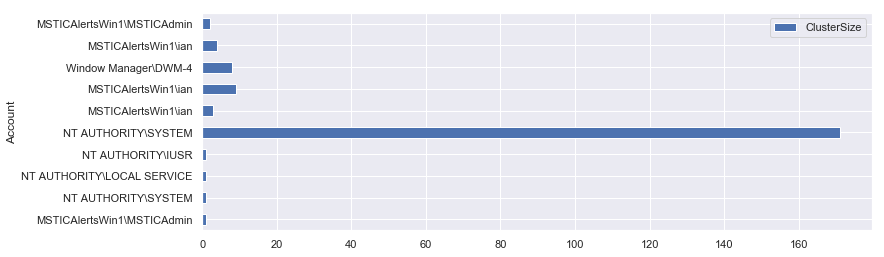

In [100]:


from msticpy.sectools.eventcluster import dbcluster_events, add_process_features, _string_score

host_logons = qry.list_host_logons(provs=[logon_query_times], **params_dict)


if len(host_logons) > 0:
    logon_features = host_logons.copy()
    logon_features['AccountNum'] = host_logons.apply(lambda x: _string_score(x.Account), axis=1)
    logon_features['LogonIdNum'] = host_logons.apply(lambda x: _string_score(x.TargetLogonId), axis=1)
    logon_features['LogonHour'] = host_logons.apply(lambda x: x.TimeGenerated.hour, axis=1)

    # you might need to play around with the max_cluster_distance parameter.
    # decreasing this gives more clusters.
    (clus_logons, _, _) = dbcluster_events(data=logon_features, time_column='TimeGenerated',
                                           cluster_columns=['AccountNum',
                                                            'LogonType'],
                                           max_cluster_distance=0.0001)
    %matplotlib inline
    plt.rcParams['figure.figsize'] = (12, 4)
    clus_logons.plot.barh(x="Account", y="ClusterSize")

    display(Markdown(f'Number of input events: {len(host_logons)}'))
    display(Markdown(f'Number of clustered events: {len(clus_logons)}'))
    display(Markdown('#### Distinct host logon patterns'))
    clus_logons.sort_values('TimeGenerated')
    nbdisp.display_logon_data(clus_logons)
else:
    display(Markdown('No logon events found for host.'))

<a id='victim2_logon_types'></a>
### Classification of Logon Types by Account

In [101]:


display(Markdown('### Counts of logon events by logon type.'))
display(Markdown('Min counts for each logon type highlighted.'))
logon_by_type = (host_logons[['Account', 'LogonType', 'EventID']]
                .groupby(['Account','LogonType']).count().unstack()
                .fillna(0)
                .style
                .background_gradient(cmap='viridis', low=.5, high=0)
                .format("{0:0>3.0f}"))
display(logon_by_type)
key = 'logon type key = {}'.format('; '.join([f'{k}: {v}' for k,v in nbtools.nbdisplay._WIN_LOGON_TYPE_MAP.items()]))
display(Markdown(key))

display(Markdown('### Logon Timeline.'))
nbdisp.display_timeline(data=host_logons,
                         overlay_data=host_logons.query('LogonType == 10'),
                         alert=security_alert, 
                         source_columns=['Account', 'LogonType', 'TimeGenerated'],
                         title='All Host Logons (RDP Logons in green)')

add_observation(Observation(caption='RDP Logons seen for victim #2',
                            description='Logons by logon type.',
                            item=logon_by_type,
                            link='victim2_logon_types'))

### Counts of logon events by logon type.

Min counts for each logon type highlighted.

logon type key = 0: Unknown; 2: Interactive; 3: Network; 4: Batch; 5: Service; 7: Unlock; 8: NetworkCleartext; 9: NewCredentials; 10: RemoteInteractive; 11: CachedInteractive

### Logon Timeline.

Loading BokehJS ...

Alert start time =  2019-02-18 15:29:22


<a id='failed_logons'></a>[Contents](#toc)
## Check for Failed Logons

In [102]:


failedLogons = qry.list_host_logon_failures(provs=[logon_query_times], **params_dict)
if failedLogons.shape[0] == 0:
    display(print('No logon failures recorded for this host between {security_alert.start} and {security_alert.start}'))
else:
    display(failedLogons)
    add_observation(Observation(caption='Logon failures seen for victim #2',
                            description=f'{len(failedLogons)} Logons seen.',
                            item=failedLogons,
                            link='failed_logons'))

,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,AuthenticationPackageName,Status,IpAddress,WorkstationName
0,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-14 04:23:55.400,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,ian,MSTICAlertsWin1,S-1-0-0,,Advapi,4,Negotiate,0xc000015b,-,MSTICAlertsWin1
1,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-13 16:28:05.417,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,ian,MSTICAlertsWin1,S-1-0-0,,Advapi,4,Negotiate,0xc000015b,-,MSTICAlertsWin1
2,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-16 00:06:02.193,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,ian,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-1120,ian,MSTICAlertsWin1,S-1-0-0,,Advapi,2,Negotiate,0xc000006d,-,MSTICAlertsWin1
3,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-15 04:09:38.523,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,ian,MSTICAlertsWin1,S-1-0-0,,Advapi,4,Negotiate,0xc000015b,-,MSTICAlertsWin1


<a id='examine_win_logon_sess'></a>[Contents](#toc)
## Examine a Logon Session

### Select a Logon ID To Examine

In [103]:


import re
dist_logons = clus_logons.sort_values('TimeGenerated')[['TargetUserName', 'TimeGenerated', 
                                                        'LastEventTime', 'LogonType', 
                                                        'ClusterSize']]
items = dist_logons.apply(lambda x: (f'{x.TargetUserName}:    '
                                     f'(logontype={x.LogonType})   '
                                     f'timerange={x.TimeGenerated} - {x.LastEventTime}    '
                                     f'count={x.ClusterSize}'),
                          axis=1).values.tolist()
def get_selected_logon_cluster(selected_item):
    acct_match = re.search(r'(?P<acct>[^:]+):\s+\(logontype=(?P<l_type>[^)]+)', selected_item)
    if acct_match:
        acct = acct_match['acct']
        l_type = int(acct_match['l_type'])
        return host_logons.query('TargetUserName == @acct and LogonType == @l_type')

def get_selected_logon(selected_item):
    logon_list_regex = r'''
(?P<acct>[^:]+):\s+
\(logontype=(?P<logon_type>[^)]+)\)\s+
\(timestamp=(?P<time>[^)]+)\)\s+
logonid=(?P<logonid>[0-9a-fx)]+)
'''
    acct_match = re.search(logon_list_regex, selected_item, re.VERBOSE)
    if acct_match:
        acct = acct_match['acct']
        logon_type = int(acct_match['logon_type'])
        time_stamp = pd.to_datetime(acct_match['time'])
        logon_id = acct_match['logonid']
        return host_logons.query('TargetUserName == @acct and LogonType == @logon_type'
                                 ' and TargetLogonId == @logon_id')
    
logon_wgt = nbtools.SelectString(description='Select logon cluster to examine', 
                             item_list=items, height='200px', width='100%', auto_display=True)

Select(description='Select logon cluster to examine', layout=Layout(height='200px', width='100%'), options=('S…

In [104]:


selected_logon_cluster = get_selected_logon_cluster(logon_wgt.value)

def view_logon(x=''):
    global selected_logon
    selected_logon = get_selected_logon(x)
    display(get_selected_logon(x))
    

items = selected_logon_cluster.sort_values('TimeGenerated').apply(lambda x: (f'{x.TargetUserName}:    '
                                        f'(logontype={x.LogonType})   '
                                        f'(timestamp={x.TimeGenerated})    '
                                        f'logonid={x.TargetLogonId}'),
                             axis=1).values.tolist()
w = widgets.Select(options=items, description='Select logon instance to examine', **WIDGET_DEFAULTS)
    
interactive(view_logon, x=w)

interactive(children=(Select(description='Select logon instance to examine', layout=Layout(width='95%'), optio…

<a id='process_clustering'></a>[Contents](#toc)
## Unusual Processes on Host - Clustering
Sometimes you don't have a source process to work with. Other times it's just useful to see what else is going on on the host. This section retrieves all processes on the host within the time bounds
set in the query times widget.

You can display the raw output of this by looking at the *processes_on_host* dataframe. Just copy this into a new cell and hit Ctrl-Enter.

Usually though, the results return a lot of very repetitive and unintersting system processes so we attempt to cluster these to make the view easier to negotiate. 
To do this we process the raw event list output to extract a few features that render strings (such as commandline)into numerical values. The default below uses the following features:
- commandLineTokensFull - this is a count of common delimiters in the commandline 
  (given by this regex r'[\s\-\\/\.,"\'|&:;%$()]'). The aim of this is to capture the commandline structure while ignoring variations on what is essentially the same pattern (e.g. temporary path GUIDs, target IP or host names, etc.)
- pathScore - this sums the ordinal (character) value of each character in the path (so /bin/bash and /bin/bosh would have similar scores).
- isSystemSession - 1 if this is a root/system session, 0 if anything else.

Then we run a clustering algorithm (DBScan in this case) on the process list. The result groups similar (noisy) processes together and leaves unique process patterns as single-member clusters.

In [105]:


# Calculate time range based on the logons from previous section
logon_time = selected_logon_cluster['TimeGenerated'].min()
last_logon_time = selected_logon_cluster['TimeGenerated'].max()
time_diff = int((last_logon_time - logon_time).total_seconds() / (60 * 60) + 2)

# set the origin time to the time of our alert
proc_query_times = nbtools.QueryTime(units='hours', origin_time=logon_time,
                           before=1, after=time_diff, max_before=20, max_after=20)
proc_query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [106]:


from msticpy.sectools.eventcluster import dbcluster_events, add_process_features
print('Getting process events...', end='')
processes_on_host = qry.list_processes(provs=[proc_query_times], **params_dict)
print('done')
print('Clustering...', end='')
feature_procs = add_process_features(input_frame=processes_on_host,
                                     path_separator=params_dict['path_separator'])

feature_procs['accountNum'] = feature_procs.apply(lambda x: _string_score(x.Account), axis=1)
# you might need to play around with the max_cluster_distance parameter.
# decreasing this gives more clusters.
(clus_events, dbcluster, x_data) = dbcluster_events(data=feature_procs,
                                                    cluster_columns=['commandlineTokensFull', 
                                                                     'pathScore',
                                                                     'accountNum',
                                                                     'isSystemSession'],
                                                    max_cluster_distance=0.0001)
print('done')
print('Number of input events:', len(feature_procs))
print('Number of clustered events:', len(clus_events))
(clus_events.sort_values('TimeGenerated')[['TimeGenerated', 'LastEventTime',
                                          'NewProcessName', 'CommandLine', 
                                          'ClusterSize', 'commandlineTokensFull',
                                          'pathScore', 'isSystemSession']]
    .sort_values('ClusterSize', ascending=False))
print('done')


Getting process events...done
Clustering...done
Number of input events: 1964
Number of clustered events: 150
done


### View processes used in login session

In [107]:


selected_logon_cluster = get_selected_logon_cluster(logon_wgt.value)

def view_logon_sess(x=''):
    global selected_logon
    selected_logon = get_selected_logon(x)
    display(selected_logon)
    logonId = selected_logon['TargetLogonId'].iloc[0]
    sess_procs = (processes_on_host.query('TargetLogonId == @logonId | SubjectLogonId == @logonId')
                                          [['NewProcessName', 'CommandLine', 'TargetLogonId']]
                  .drop_duplicates())
    display(sess_procs)
    

items = selected_logon_cluster.sort_values('TimeGenerated').apply(lambda x: (f'{x.TargetUserName}:    '
                                        f'(logontype={x.LogonType})   '
                                        f'(timestamp={x.TimeGenerated})    '
                                        f'logonid={x.TargetLogonId}'),
                             axis=1).values.tolist()
sess_w = widgets.Select(options=items, description='Select logon instance to examine', **WIDGET_DEFAULTS)
    
interactive(view_logon_sess, x=sess_w)

interactive(children=(Select(description='Select logon instance to examine', layout=Layout(width='95%'), optio…

### Save Selected Session as Observation

In [108]:


if selected_logon is not None:
    display(Markdown('**Attacker Logon Session selected**'))
    display(selected_logon)
    logonid = selected_logon['TargetLogonId'].iloc[0]
    logon_time = selected_logon['TimeGenerated'].iloc[0]
    subj_account = entity.Account(src_event=selected_logon.iloc[0], role='subject')
    tgt_account = entity.Account(src_event=selected_logon.iloc[0], role='target')
    logon_session = entity.HostLogonSession(src_event=selected_logon.iloc[0])
    logon_session.Account = tgt_account
    logon_session.SessionId = logonid
    logon_session.Host = inv_host_entity
    display(Markdown('**Entities:**'))
    print('Subject Account:\n', subj_account)
    print('Target Account Session:\n', logon_session)
    
    add_observation(Observation(caption='Logon session identified for attacker IP',
                            description=f'Logon session for account {logon_session.Account.Name}',
                            item=logon_session,
                            link='examine_win_logon_sess'))

**Attacker Logon Session selected**

,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,AuthenticationPackageName,Status,IpAddress,WorkstationName
121,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4624,2019-02-15 19:54:24.590,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,ian,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-1120,0x1cfd78d,User32,10,Negotiate,,13.67.35.176,MSTICAlertsWin1


**Entities:**

Subject Account:
 {'Name': 'MSTICAlertsWin1$', 'Sid': 'S-1-5-18', 'Type': 'account'}
Target Account Session:
 { 'Account': { 'LogonId': '0x1cfd78d',
               'Name': 'ian',
               'Sid': 'S-1-5-21-996632719-2361334927-4038480536-1120',
               'Type': 'account'},
  'EndTimeUtc': Timestamp('2019-02-15 19:54:24.590000'),
  'Host': { 'AdditionalData': { 'OSMajorVersion': '18',
                                'OSMinorVersion': '04',
                                'SourceComputerId': '44623fb0-bd5f-49ea-84d1-56aa11ab8a25'},
            'HostName': 'MSTICALERTSLXVM2',
            'OSFamily': 'Linux',
            'Type': 'host',
            'private_ips': [{"Address": "10.0.3.4", "Type": "ipaddress"}],
            'public_ips': [ {"Address": "104.211.30.1", "Location": {"CountryCode": "US", "CountryName": "United States", "State": "Virginia", "City": "Washington", "Longitude": -78.1704, "Latitude": 38.7163, "Type": "geolocation"}, "Type": "ipaddress"}]},
  'SessionId': '

<a id='process_session'></a>[Contents](#toc)
### Processes for Selected LogonId

In [109]:
logonId = selected_logon['TargetLogonId'].iloc[0]
sess_procs = (processes_on_host.query('TargetLogonId == @logonId | SubjectLogonId == @logonId')
                                          [['TimeGenerated', 'NewProcessName', 'CommandLine']])

display(sess_procs)
add_observation(Observation(caption='Attacker commands on Victim 2',
                            description=f'Processes run in Attacker session',
                            item=sess_procs,
                            link='process_session'))

,TimeGenerated,NewProcessName,CommandLine
204,2019-02-16 04:38:47.097,C:\Program Files (x86)\Google\Chrome\Application\chrome.exe,"""C:\Program Files (x86)\Google\Chrome\Application\chrome.exe"" --type=utility --field-trial-handle=1484,12783180547655760324,4474440899781287527,131072 --lang=en-US --service-sandbox-type=utility --service-request-channel-token=2789652684418032134 --mojo-platform-channel-handle=6152 --ignored="" -..."
280,2019-02-16 03:54:26.030,C:\Windows\System32\taskhostw.exe,taskhostw.exe USER
362,2019-02-16 03:00:00.593,C:\Windows\System32\AppHostRegistrationVerifier.exe,C:\Windows\system32\AppHostRegistrationVerifier.exe
363,2019-02-16 03:00:00.833,C:\Windows\System32\AppHostRegistrationVerifier.exe,C:\Windows\system32\AppHostRegistrationVerifier.exe
376,2019-02-16 03:26:59.267,C:\Windows\System32\net.exe,net localgroup administrators abai$ /delete
377,2019-02-16 03:26:59.290,C:\Windows\System32\net1.exe,C:\Windows\system32\net1 localgroup administrators abai$ /delete
378,2019-02-16 03:26:59.317,C:\Windows\System32\net.exe,net user qf938$ /delete
379,2019-02-16 03:26:59.330,C:\Windows\System32\net1.exe,C:\Windows\system32\net1 user qf938$ /delete
380,2019-02-16 03:26:59.357,C:\Windows\System32\cmd.exe,cmd /c echo End Security Demo tasks
391,2019-02-16 03:28:44.100,C:\Windows\System32\TSTheme.exe,C:\Windows\system32\TSTheme.exe -Embedding


### Clustered Version of Previous Query - collapsing duplicates

In [110]:
display(clus_events.query('TargetLogonId == @logonId | SubjectLogonId == @logonId')
        [['TimeGenerated', 'NewProcessName', 'CommandLine', 'ClusterSize']])

,TimeGenerated,NewProcessName,CommandLine,ClusterSize
563,2019-02-16 03:24:51.140,C:\Windows\System32\AtBroker.exe,atbroker.exe,1
609,2019-02-16 03:26:24.180,C:\Windows\System32\notepad.exe,"""C:\Windows\System32\NOTEPAD.EXE"" C:\Diagnostics\SimulateAttack.cmd",1
721,2019-02-16 00:02:26.290,C:\Windows\System32\mmc.exe,"""C:\Windows\system32\mmc.exe"" C:\Windows\system32\devmgmt.msc",1
730,2019-02-16 00:02:41.220,C:\Windows\explorer.exe,"C:\Windows\explorer.exe /factory,{ceff45ee-c862-41de-aee2-a022c81eda92} -Embedding",1
776,2019-02-16 00:14:27.470,C:\Users\ian\AppData\Local\Google\Chrome\User Data\SwReporter\38.190.200\software_reporter_tool.exe,"""C:\Users\ian\AppData\Local\Google\Chrome\User Data\SwReporter\38.190.200\software_reporter_tool.exe"" --engine=2 --session-id=xK+PhwgHSEiL/nt2hOFZJfmK2fIAESx5Y4KjzoiB --registry-suffix=ESET --enable-crash-reporting --srt-field-trial-group-name=NewCleanerUIExperiment",1
777,2019-02-16 00:14:28.130,C:\Users\ian\AppData\Local\Google\Chrome\User Data\SwReporter\38.190.200\software_reporter_tool.exe,"""c:\users\ian\appdata\local\google\chrome\user data\swreporter\38.190.200\software_reporter_tool.exe"" --crash-handler ""--database=c:\users\ian\appdata\local\Google\Software Reporter Tool"" --url=https://clients2.google.com/cr/report --annotation=plat=Win32 --annotation=prod=ChromeFoil --annotatio...",1
778,2019-02-16 00:14:28.273,C:\Users\ian\AppData\Local\Google\Chrome\User Data\SwReporter\38.190.200\software_reporter_tool.exe,"""c:\users\ian\appdata\local\google\chrome\user data\swreporter\38.190.200\software_reporter_tool.exe"" --enable-crash-reporting --use-crash-handler-with-id=""\\.\pipe\crashpad_4212_HBQUEAMMUFPSUNPC"" --sandboxed-process-id=2 --init-done-notifier=680 --sandbox-mojo-pipe-token=869410672342228469 --mo...",1
779,2019-02-16 00:14:28.737,C:\Users\ian\AppData\Local\Google\Chrome\User Data\SwReporter\38.190.200\software_reporter_tool.exe,"""c:\users\ian\appdata\local\google\chrome\user data\swreporter\38.190.200\software_reporter_tool.exe"" --enable-crash-reporting --use-crash-handler-with-id=""\\.\pipe\crashpad_4212_HBQUEAMMUFPSUNPC"" --sandboxed-process-id=3 --init-done-notifier=872 --sandbox-mojo-pipe-token=2532931197943106128 --m...",1
907,2019-02-16 00:05:21.987,C:\Program Files (x86)\Google\Chrome\Application\chrome.exe,"""C:\Program Files (x86)\Google\Chrome\Application\chrome.exe""",1
908,2019-02-16 00:05:22.020,C:\Program Files (x86)\Google\Chrome\Application\chrome.exe,"""C:\Program Files (x86)\Google\Chrome\Application\chrome.exe"" --type=crashpad-handler ""--user-data-dir=C:\Users\ian\AppData\Local\Google\Chrome\User Data"" /prefetch:7 --monitor-self-annotation=ptype=crashpad-handler ""--database=C:\Users\ian\AppData\Local\Google\Chrome\User Data\Crashpad"" ""--metr...",1


### Optional (for the curious) - View clustering stats

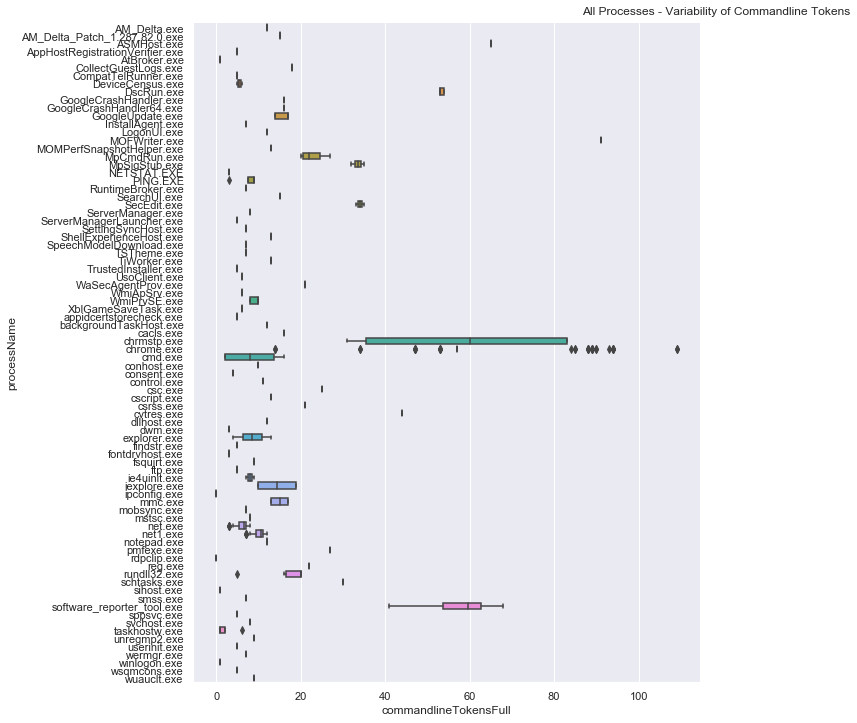

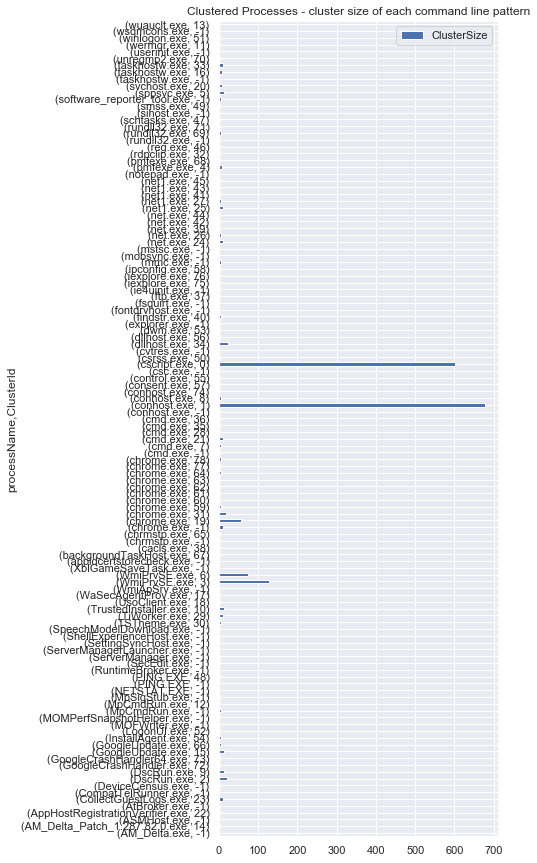

In [111]:

# change False to True in the if statement to see this
if True:
    proc_plot = sns.catplot(y="processName", x="commandlineTokensFull", 
                            data=feature_procs.sort_values('processName'),
                            kind='box', height=10)
    proc_plot.fig.suptitle('All Processes - Variability of Commandline Tokens', x=1, y=1)

    plt.rcParams['figure.figsize'] = (5, 15)
    clus_plot = clus_events[['processName', 
                             'ClusterId', 
                             'ClusterSize']].groupby(['processName', 
                                                      'ClusterId']).sum().plot.barh()
    plt.title('Clustered Processes - cluster size of each command line pattern');

<a id='other_win_events'></a>[Contents](#toc)
## Other Events on the Host

In [112]:


all_events_base_qry = '''
SecurityEvent
| where Computer =~ '{host}'
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| where {where_filter}
'''
all_events_qry = all_events_base_qry.format(host=params_dict['host_name'],
                                            start=proc_query_times.start,
                                            end=proc_query_times.end,
                                            where_filter='EventID != 4688 and EventID != 4624')

%kql -query all_events_qry
all_events_df = _kql_raw_result_.to_dataframe()
display(all_events_df[['Account', 'Activity', 'TimeGenerated']].groupby(['Account', 'Activity']).count())

add_observation(Observation(caption='System account modifications during attack.',
                            description='Count of event types seen on system',
                            item=all_events_df[['Account', 'Activity', 'TimeGenerated']].groupby(['Account', 'Activity']).count(),
                            link='other_win_events'))

TimeGenerated
Account                    Activity                                                                                            
                           4776 - The domain controller attempted to validate the credentials for an account.                 7
                           5058 - Key file operation.                                                                        13
                           5061 - Cryptographic operation.                                                                   13
MSTICAlertsWin1\MSTICAdmin 4634 - An account was logged off.                                                                  1
                           4798 - A user's local group membership was enumerated.                                             1
                           8002 - A process was allowed to run.                                                              51
MSTICAlertsWin1\ian        4625 - An account failed to log on.                                                                1
                           4634 - An account was logged off.                                                                  7
                           4672 - Special privileges assigned to new logon.                                                  11
                           4720 - A user account was created.                                                                 1
                           4722 - A user account was enabled.                                                                 1
                           4724 - An attempt was made to reset an account's password.                                         2
                           4726 - A user account was deleted.                                                                 1
                           4728 - A member was added to a security-enabled global group.                                      1
                           4729 - A member was removed from a security-enabled global group.                                  1
                           4732 - A member was added to a security-enabled local group.                                       2
                           4733 - A member was removed from a security-enabled local group.                                   2
                           4738 - A user account was changed.                                                                 3
                           4797 - An attempt was made to query the existence of a blank password for an account.              4
                           4798 - A user's local group membership was enumerated.                                            26
                           4799 - A security-enabled local group membership was enumerated                                    3
                           8002 - A process was allowed to run.                                                             226
NT AUTHORITY\SYSTEM        4672 - Special privileges assigned to new logon.                                                  18
                           8002 - A process was allowed to run.                                                               6
WORKGROUP\MSTICAlertsWin1$ 4648 - A logon was attempted using explicit credentials.                                           5
                           4798 - A user's local group membership was enumerated.                                            84
                           4799 - A security-enabled local group membership was enumerated                                   33
                           5059 - Key migration operation.                                                                   22
Window Manager\DWM-3       4672 - Special privileges assigned to new logon.                                                   2
Window Manager\DWM-4       4634 - An account was logged off.                                                                  2
                  

In [113]:


# Function to convert EventData XML into dictionary and populate columns into DataFrame from previous query result
all_events_df['EventData'].iloc[10]
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import ParseError
SCHEMA='http://schemas.microsoft.com/win/2004/08/events/event'
def parse_event_data(row):
    try:
        xdoc = ET.fromstring(row.EventData)
        col_dict = {elem.attrib['Name']: elem.text for elem in xdoc.findall(f'{{{SCHEMA}}}Data')}
        reassigned = set()
        for k, v in col_dict.items():
            if k in row and not row[k]:
                row[k] = v
                reassigned.add(k)
        if reassigned:
            #print('Reassigned: ', ', '.join(reassigned))
            for k in reassigned:
                col_dict.pop(k)
        return col_dict
    except ParseError:
        return None

all_events_df['EventProperties'] = all_events_df.apply(parse_event_data, axis=1)


<a id='o365'></a>[Contents](#toc)
# Office 365 Activity

In [114]:


# set the origin time to the time of our alert
o365_query_times = nbtools.QueryTime(units='hours', origin_time=security_alert.origin_time,
                           before=1, after=10, max_before=20, max_after=20)
o365_query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

### Execute queries to get the data

In [118]:


print('Running queries...', end=' ')
# Queries
ad_changes_query = '''
OfficeActivity
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| where RecordType == 'AzureActiveDirectory'
| where Operation in ('Add service principal.',
                      'Change user password.', 
                      'Add user.', 
                      'Add member to role.')
| where UserType == 'Regular' 
| project OfficeId, TimeGenerated, Operation, OrganizationId, 
          OfficeWorkload, ResultStatus, OfficeObjectId, 
          UserId = tolower(UserId), ClientIP, ExtendedProperties
'''.format(start = o365_query_times.start, end=o365_query_times.end)
%kql -query ad_changes_query
ad_changes_df = _kql_raw_result_.to_dataframe()


office_ops_query = '''
OfficeActivity
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| where RecordType in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
| extend UserAgent = extractjson("$[0].Value", ExtendedProperties, typeof(string))
| union (
    OfficeActivity 
    | where TimeGenerated >= datetime({start})
    | where TimeGenerated <= datetime({end})
    | where RecordType !in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
)
| where UserType == 'Regular'
'''.format(start = o365_query_times.start, end=o365_query_times.end)
%kql -query office_ops_query
office_ops_df = _kql_raw_result_.to_dataframe()

office_ops_summary_query = '''
let timeRange=ago(30d);
let officeAuthentications = OfficeActivity
| where TimeGenerated >= timeRange
| where RecordType in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
| extend UserAgent = extractjson("$[0].Value", ExtendedProperties, typeof(string))
| where Operation == "UserLoggedIn";
officeAuthentications
| union (
    OfficeActivity 
    | where TimeGenerated >= timeRange
    | where RecordType !in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
)
| where UserType == 'Regular'
| extend RecordOp = strcat(RecordType, '-', Operation)
| summarize OpCount=count() by RecordType, Operation, UserId, UserAgent, ClientIP, bin(TimeGenerated, 1h)
// render timeline
'''.format(start = o365_query_times.start, end=o365_query_times.end)
%kql -query office_ops_summary_query
office_ops_summary_df = _kql_raw_result_.to_dataframe()
# %kql -query office_ops_query
# office_ops_df = _kql_raw_result_.to_dataframe()

office_logons_query = '''
let timeRange=ago(30d);
let officeAuthentications = OfficeActivity
| where TimeGenerated >= timeRange
| where RecordType in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
| extend UserAgent = extractjson("$[0].Value", ExtendedProperties, typeof(string))
| where Operation == "UserLoggedIn";
let lookupWindow = 1d;
let lookupBin = lookupWindow / 2.0; 
officeAuthentications | project-rename Start=TimeGenerated
| extend TimeKey = bin(Start, lookupBin)
| join kind = inner (
    officeAuthentications
    | project-rename End=TimeGenerated
    | extend TimeKey = range(bin(End - lookupWindow, lookupBin), bin(End, lookupBin), lookupBin)
    | mvexpand TimeKey to typeof(datetime)
) on UserAgent, TimeKey
| project timeSpan = End - Start, UserId, ClientIP , UserAgent , Start, End
| summarize dcount(ClientIP) by  UserAgent
| where dcount_ClientIP > 1
| join kind=inner (  
officeAuthentications
| summarize minTime=min(TimeGenerated), maxTime=max(TimeGenerated) by UserId, UserAgent, ClientIP
) on UserAgent
'''
%kql -query office_logons_query
office_logons_df = _kql_raw_result_.to_dataframe()

print('done.')

Running queries... done.


<a id='o365_match_ip'></a>
### Any IP Addresses in our alert IPs that match Office Activity?

In [119]:
# Any IP Addresses in our alert IPs that match?


for ip in alert_ip_entities:
    susp_o365_activities = office_ops_df[office_ops_df['ClientIP'] == ip.Address]
    susp_o365_summ = (office_ops_df[office_ops_df['ClientIP'] == ip.Address]
                         [['OfficeId', 'UserId', 'RecordType', 'Operation']]
                         .groupby(['UserId', 'RecordType', 'Operation']).count()
                         .rename(columns={'OfficeId': 'OperationCount'}))
    
    display(Markdown(f'### Activity for {ip.Address}'))
    
    if len(susp_o365_summ) > 0:
        display(susp_o365_summ)
    
        add_observation(Observation(caption=f'O365 activity from suspected attacker IP {ip.Address}',
                                    description=f'Summarized operation count for each user/service/operation type',
                                    item=susp_o365_summ,
                                    link='o365_match_ip'))
    else:
        display(Markdown('No activity detected'))

### Activity for 23.97.60.214

No activity detected

In [120]:


for susp_ip in [ip.Address for ip in alert_ip_entities]:

    display(Markdown(f'### Timeline of operations originating from suspect IP Address: {susp_ip}'))
    display(Markdown(f'**{susp_ip}**'))
    suspect_ip_ops = office_ops_df[office_ops_df['ClientIP'] == susp_ip]
    if len(suspect_ip_ops) == 0:
        display(Markdown('No activity detected'))
        continue
    sel_op_type='FileDownloaded'
    nbdisp.display_timeline(data=suspect_ip_ops, title=f'Operations from {susp_ip} (all=blue, {sel_op_type}=green)',
                             overlay_data=suspect_ip_ops.query('Operation == @sel_op_type'),
                            source_columns=['UserId', 'RecordType', 'Operation'])
    
    # Uncomment line below to see all activity
    # display(suspect_ip_ops.sort_values('TimeGenerated', ascending=True).head())


### Timeline of operations originating from suspect IP Address: 23.97.60.214

**23.97.60.214**

No activity detected

<a id="o356_high_freq"></a>
### Look for high-frequency operations - like automated or bulk uploads/downloads
#### Anything above or approaching 1 operation/sec is likely an automated or bulk operation

In [ ]:


timed_slice_ops = office_ops_df[['RecordType', 'TimeGenerated', 'Operation'
       'OrganizationId', 'UserType', 'OfficeWorkload',
       'ResultStatus', 'OfficeObjectId', 'UserId', 'ClientIP', 'Start_Time']]
timed_slice_ops2 = timed_slice_ops.set_index('TimeGenerated')

hi_freq_ops = (timed_slice_ops2[['UserId', 'ClientIP', 'Operation', 'RecordType']]
                .groupby(['UserId', 'ClientIP', 'RecordType', 'Operation']).resample('10S').count()
                .query('RecordType > 10')
                .drop(['ClientIP', 'UserId', 'RecordType'], axis=1)
                .assign(OpsPerSec = lambda x: x.Operation / 10)
                .rename(columns={'Operation': 'Operation Count'}))

if len(hi_freq_ops) > 0:
    display(hi_freq_ops)
    add_observation(Observation(caption=f'O365 bulk/high freq operations seen',
                                    description=f'Summarized operation count bulk actions',
                                    item=hi_freq_ops,
                                    link='o356_high_freq'))

## Other Background Data for O365

In [ ]:


display(Markdown('### IPs and User Agents - frequency of use'))
office_ops_df['UserId'] = office_ops_df['UserId'].str.lower()
display(Markdown('Distinct IPs by num of operations'))
display(office_ops_df[['ClientIP', 'Operation']].groupby(['ClientIP']).count())
display(Markdown('Distinct UserAgents by num of operations'))
office_ops_df[['UserAgent', 'Operation']].groupby(['UserAgent']).count()


In [ ]:


off_ip_locs = (office_ops_df[['ClientIP']]
                   .drop_duplicates()
                   .apply(lambda x: 
                          iplocation.lookup_ip(ip_address=x.ClientIP)[1]
                          if x.ClientIP and x.ClientIP != '<null>' else None, axis=1)
                   .tolist())
ip_locs = [ip_list[0] for ip_list in off_ip_locs if ip_list]
    
flow_map = create_ip_map()
display(HTML('<h3>External IP Addresses seen in Office Activity</h3>'))
display(HTML('Numbered circles indicate multiple items - click to expand.'))


icon_props = {'color': 'purple'}
flow_map = add_ip_cluster(folium_map=flow_map,
                            ip_entities=ip_locs,
                            **icon_props)
display(flow_map)

display(Markdown('<p style="color:red">Warning: the folium mapping library '
                 'does not display correctly in some browsers.</p><br>'
                 'If you see a blank image please retry with a different browser.'))

In [ ]:


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    display(Markdown('### Change in rate of Activity Class (RecordType) and Operation'))
    sns.relplot(data=office_ops_summary_df, x='TimeGenerated', y='OpCount', kind='line', aspect=2, 
                hue='RecordType')
    sns.relplot(data=office_ops_summary_df.query('RecordType == "SharePointFileOperation"'), 
                x='TimeGenerated', y='OpCount', hue='Operation', kind='line', aspect=2)



In [ ]:


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    display(Markdown('### Identify Users/IPs with largest operation count'))
    office_ops_summary_df['UserId'] = office_ops_summary_df['UserId'].str.lower()

    sns.catplot(data=office_ops_summary_df, x='UserId', y='OpCount', 
                hue='Operation', aspect=2).set_xticklabels(rotation=30)
    office_ops_summary_df.pivot_table('OpCount', index=['ClientIP', 'UserId'], 
                                      columns='Operation').style.bar(color='orange', align='mid')

### Extract distinctive events from O365 Operations

In [ ]:


from msticpy.sectools.eventcluster import (dbcluster_events, 
                                           add_process_features, 
                                           char_ord_score,
                                           token_count,
                                           delim_count)

feature_office_ops = office_ops_df.copy()
feature_office_ops['ip_num'] = feature_office_ops.apply(lambda x: char_ord_score(x, 'ClientIP'), axis=1)
feature_office_ops['ua_tokens'] = feature_office_ops.apply(lambda x: char_ord_score(x, 'UserAgent'), axis=1)
feature_office_ops['oid_tokens'] = feature_office_ops.apply(lambda x: char_ord_score(x, 'OfficeObjectId'), axis=1)

# you might need to play around with the max_cluster_distance parameter.
# decreasing this gives more clusters.
(clustered_ops, dbcluster, x_data) = dbcluster_events(data=feature_office_ops,
                                                      cluster_columns=['ip_num', 
                                                                     'ua_tokens', 
                                                                     'oid_tokens'],
                                                      time_column='TimeGenerated',
                                                      max_cluster_distance=0.0001)
print('Number of input events:', len(feature_office_ops))
print('Number of clustered events:', len(clustered_ops))
(clustered_ops[['TimeGenerated', 'RecordType',
                'Operation', 'UserId', 'UserAgent', 'ClusterSize',
                'OfficeObjectId']]
    .query('ClusterSize <= 2')
    .sort_values('ClusterSize', ascending=True))

<a id='summary'></a>[Contents](#toc)
# Summary

In [ ]:
for observation in observation_list.values():
    display_observation(observation)
    

<a id='appendices'></a>[Contents](#toc)
# Appendices

## Available DataFrames

In [ ]:
print('List of current DataFrames in Notebook')
print('-' * 50)
current_vars = list(locals().keys())
for var_name in current_vars:
    if isinstance(locals()[var_name], pd.DataFrame) and not var_name.startswith('_'):
        print(var_name)

## Saving Data to Excel
To save the contents of a pandas DataFrame to an Excel spreadsheet
use the following syntax
```
writer = pd.ExcelWriter('myWorksheet.xlsx')
my_data_frame.to_excel(writer,'Sheet1')
writer.save()
```

## Platform Requirements
**Python Version:** Python 3.6 (including Python 3.6 - AzureML)<br>
**Required Packages**: kqlmagic, msticpy, pandas, numpy, matplotlib, networkx, ipywidgets, ipython, scikit_learn, dnspython, ipwhois, folium, maxminddb_geolite2<br>
**Platforms Supported**:
- Azure Notebooks Free Compute
- Azure Notebooks DSVM
- OS Independent

**Data Sources Required**:
- Log Analytics - SecurityAlert, SecurityEvent (EventIDs 4688 and 4624/25), AuditLog_CL (Linux Auditd), OfficeActivity, AzureNetworkAnalytics_CL, Heartbeat
- (Optional) - VirusTotal (with API key)